In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_075_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2604842, 828)
(2604842, 8)
validation
(311642, 828)
(311642, 8)
test
(384133, 828)
(384133, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/261 [..............................] - ETA: 7:03 - loss: 2.1427 - STD: 0.0521 - MAE: 0.2185

  4/261 [..............................] - ETA: 5s - loss: 2.1047 - STD: 0.0329 - MAE: 0.2184  

  7/261 [..............................] - ETA: 5s - loss: 2.0984 - STD: 0.0280 - MAE: 0.2185

 10/261 [>.............................] - ETA: 5s - loss: 2.0897 - STD: 0.0247 - MAE: 0.2184

 13/261 [>.............................] - ETA: 5s - loss: 2.0853 - STD: 0.0247 - MAE: 0.2182

 16/261 [>.............................] - ETA: 5s - loss: 2.0785 - STD: 0.0232 - MAE: 0.2181

 19/261 [=>............................] - ETA: 5s - loss: 2.0696 - STD: 0.0224 - MAE: 0.2178

 22/261 [=>............................] - ETA: 5s - loss: 2.0579 - STD: 0.0234 - MAE: 0.2174

 25/261 [=>............................] - ETA: 5s - loss: 2.0444 - STD: 0.0262 - MAE: 0.2168

 28/261 [==>...........................] - ETA: 5s - loss: 2.0302 - STD: 0.0299 - MAE: 0.2160

 31/261 [==>...........................] - ETA: 5s - loss: 2.0156 - STD: 0.0335 - MAE: 0.2152

 34/261 [==>...........................] - ETA: 5s - loss: 2.0017 - STD: 0.0369 - MAE: 0.2145

 37/261 [===>..........................] - ETA: 5s - loss: 1.9885 - STD: 0.0401 - MAE: 0.2137

 40/261 [===>..........................] - ETA: 5s - loss: 1.9755 - STD: 0.0429 - MAE: 0.2130

 43/261 [===>..........................] - ETA: 4s - loss: 1.9627 - STD: 0.0457 - MAE: 0.2123

 44/261 [====>.........................] - ETA: 9s - loss: 1.9605 - STD: 0.0466 - MAE: 0.2121

 47/261 [====>.........................] - ETA: 8s - loss: 1.9467 - STD: 0.0492 - MAE: 0.2113

 50/261 [====>.........................] - ETA: 8s - loss: 1.9319 - STD: 0.0516 - MAE: 0.2105

 53/261 [=====>........................] - ETA: 8s - loss: 1.9158 - STD: 0.0540 - MAE: 0.2097

 56/261 [=====>........................] - ETA: 7s - loss: 1.8992 - STD: 0.0567 - MAE: 0.2088

 59/261 [=====>........................] - ETA: 7s - loss: 1.8821 - STD: 0.0593 - MAE: 0.2078

 62/261 [======>.......................] - ETA: 7s - loss: 1.8645 - STD: 0.0621 - MAE: 0.2068

 65/261 [======>.......................] - ETA: 7s - loss: 1.8473 - STD: 0.0649 - MAE: 0.2057

 68/261 [======>.......................] - ETA: 6s - loss: 1.8302 - STD: 0.0678 - MAE: 0.2046

 71/261 [=======>......................] - ETA: 6s - loss: 1.8141 - STD: 0.0706 - MAE: 0.2036

 74/261 [=======>......................] - ETA: 6s - loss: 1.7984 - STD: 0.0732 - MAE: 0.2025

 77/261 [=======>......................] - ETA: 6s - loss: 1.7833 - STD: 0.0758 - MAE: 0.2015

 80/261 [========>.....................] - ETA: 6s - loss: 1.7694 - STD: 0.0782 - MAE: 0.2006

 83/261 [========>.....................] - ETA: 5s - loss: 1.7559 - STD: 0.0806 - MAE: 0.1996

 86/261 [========>.....................] - ETA: 5s - loss: 1.7430 - STD: 0.0829 - MAE: 0.1987

 89/261 [=========>....................] - ETA: 5s - loss: 1.7306 - STD: 0.0851 - MAE: 0.1978

 92/261 [=========>....................] - ETA: 5s - loss: 1.7187 - STD: 0.0872 - MAE: 0.1969

 95/261 [=========>....................] - ETA: 5s - loss: 1.7074 - STD: 0.0892 - MAE: 0.1961

 98/261 [==========>...................] - ETA: 5s - loss: 1.6966 - STD: 0.0912 - MAE: 0.1953

101/261 [==========>...................] - ETA: 5s - loss: 1.6862 - STD: 0.0930 - MAE: 0.1945

104/261 [==========>...................] - ETA: 4s - loss: 1.6761 - STD: 0.0948 - MAE: 0.1938

107/261 [===========>..................] - ETA: 4s - loss: 1.6663 - STD: 0.0965 - MAE: 0.1930

110/261 [===========>..................] - ETA: 4s - loss: 1.6571 - STD: 0.0982 - MAE: 0.1923

113/261 [===========>..................] - ETA: 4s - loss: 1.6483 - STD: 0.0997 - MAE: 0.1916

116/261 [============>.................] - ETA: 4s - loss: 1.6397 - STD: 0.1012 - MAE: 0.1910

119/261 [============>.................] - ETA: 4s - loss: 1.6314 - STD: 0.1027 - MAE: 0.1903

122/261 [=============>................] - ETA: 4s - loss: 1.6234 - STD: 0.1042 - MAE: 0.1897

125/261 [=============>................] - ETA: 4s - loss: 1.6159 - STD: 0.1055 - MAE: 0.1891

128/261 [=============>................] - ETA: 3s - loss: 1.6086 - STD: 0.1068 - MAE: 0.1885

131/261 [==============>...............] - ETA: 3s - loss: 1.6016 - STD: 0.1081 - MAE: 0.1879

134/261 [==============>...............] - ETA: 3s - loss: 1.5947 - STD: 0.1093 - MAE: 0.1874

137/261 [==============>...............] - ETA: 3s - loss: 1.5879 - STD: 0.1105 - MAE: 0.1869

140/261 [===============>..............] - ETA: 3s - loss: 1.5816 - STD: 0.1117 - MAE: 0.1863

143/261 [===============>..............] - ETA: 3s - loss: 1.5756 - STD: 0.1127 - MAE: 0.1859

146/261 [===============>..............] - ETA: 3s - loss: 1.5695 - STD: 0.1138 - MAE: 0.1854

149/261 [================>.............] - ETA: 3s - loss: 1.5636 - STD: 0.1148 - MAE: 0.1849

152/261 [================>.............] - ETA: 3s - loss: 1.5580 - STD: 0.1159 - MAE: 0.1844

155/261 [================>.............] - ETA: 3s - loss: 1.5526 - STD: 0.1168 - MAE: 0.1840

158/261 [=================>............] - ETA: 2s - loss: 1.5471 - STD: 0.1178 - MAE: 0.1836

161/261 [=================>............] - ETA: 2s - loss: 1.5420 - STD: 0.1187 - MAE: 0.1831

164/261 [=================>............] - ETA: 2s - loss: 1.5370 - STD: 0.1196 - MAE: 0.1827

167/261 [==================>...........] - ETA: 2s - loss: 1.5320 - STD: 0.1205 - MAE: 0.1823

170/261 [==================>...........] - ETA: 2s - loss: 1.5270 - STD: 0.1214 - MAE: 0.1819

173/261 [==================>...........] - ETA: 2s - loss: 1.5223 - STD: 0.1223 - MAE: 0.1815

176/261 [===================>..........] - ETA: 2s - loss: 1.5176 - STD: 0.1231 - MAE: 0.1811

179/261 [===================>..........] - ETA: 2s - loss: 1.5130 - STD: 0.1239 - MAE: 0.1807

182/261 [===================>..........] - ETA: 2s - loss: 1.5084 - STD: 0.1247 - MAE: 0.1803

185/261 [====================>.........] - ETA: 2s - loss: 1.5040 - STD: 0.1255 - MAE: 0.1800

188/261 [====================>.........] - ETA: 2s - loss: 1.4998 - STD: 0.1262 - MAE: 0.1796

191/261 [====================>.........] - ETA: 1s - loss: 1.4959 - STD: 0.1269 - MAE: 0.1792

194/261 [=====================>........] - ETA: 1s - loss: 1.4918 - STD: 0.1277 - MAE: 0.1789

197/261 [=====================>........] - ETA: 1s - loss: 1.4880 - STD: 0.1284 - MAE: 0.1786

200/261 [=====================>........] - ETA: 1s - loss: 1.4841 - STD: 0.1291 - MAE: 0.1782

203/261 [======================>.......] - ETA: 1s - loss: 1.4802 - STD: 0.1298 - MAE: 0.1779

206/261 [======================>.......] - ETA: 1s - loss: 1.4765 - STD: 0.1304 - MAE: 0.1776

209/261 [=======================>......] - ETA: 1s - loss: 1.4729 - STD: 0.1311 - MAE: 0.1773

212/261 [=======================>......] - ETA: 1s - loss: 1.4693 - STD: 0.1317 - MAE: 0.1769

215/261 [=======================>......] - ETA: 1s - loss: 1.4659 - STD: 0.1323 - MAE: 0.1766

218/261 [========================>.....] - ETA: 1s - loss: 1.4623 - STD: 0.1330 - MAE: 0.1763

221/261 [========================>.....] - ETA: 1s - loss: 1.4589 - STD: 0.1335 - MAE: 0.1760

224/261 [========================>.....] - ETA: 0s - loss: 1.4556 - STD: 0.1341 - MAE: 0.1758

227/261 [=========================>....] - ETA: 0s - loss: 1.4522 - STD: 0.1347 - MAE: 0.1755

230/261 [=========================>....] - ETA: 0s - loss: 1.4488 - STD: 0.1353 - MAE: 0.1752

233/261 [=========================>....] - ETA: 0s - loss: 1.4455 - STD: 0.1358 - MAE: 0.1749

236/261 [==========================>...] - ETA: 0s - loss: 1.4425 - STD: 0.1364 - MAE: 0.1746

239/261 [==========================>...] - ETA: 0s - loss: 1.4393 - STD: 0.1369 - MAE: 0.1743

242/261 [==========================>...] - ETA: 0s - loss: 1.4361 - STD: 0.1375 - MAE: 0.1741

245/261 [===========================>..] - ETA: 0s - loss: 1.4331 - STD: 0.1380 - MAE: 0.1738

248/261 [===========================>..] - ETA: 0s - loss: 1.4301 - STD: 0.1385 - MAE: 0.1735

251/261 [===========================>..] - ETA: 0s - loss: 1.4273 - STD: 0.1390 - MAE: 0.1733

254/261 [============================>.] - ETA: 0s - loss: 1.4245 - STD: 0.1395 - MAE: 0.1730

257/261 [============================>.] - ETA: 0s - loss: 1.4217 - STD: 0.1400 - MAE: 0.1728

260/261 [============================>.] - ETA: 0s - loss: 1.4189 - STD: 0.1405 - MAE: 0.1725

261/261 [==============================] - 10s 30ms/step - loss: 1.4180 - STD: 0.1407 - MAE: 0.1724 - val_loss: 1.2793 - val_STD: 0.1807 - val_MAE: 0.1531


Epoch 2/10000


  1/261 [..............................] - ETA: 12s - loss: 1.1770 - STD: 0.1804 - MAE: 0.1515

  4/261 [..............................] - ETA: 4s - loss: 1.1891 - STD: 0.1813 - MAE: 0.1518 

  7/261 [..............................] - ETA: 5s - loss: 1.1878 - STD: 0.1823 - MAE: 0.1514

 10/261 [>.............................] - ETA: 5s - loss: 1.1893 - STD: 0.1825 - MAE: 0.1514

 13/261 [>.............................] - ETA: 5s - loss: 1.1844 - STD: 0.1826 - MAE: 0.1511

 16/261 [>.............................] - ETA: 5s - loss: 1.1819 - STD: 0.1827 - MAE: 0.1510

 19/261 [=>............................] - ETA: 5s - loss: 1.1785 - STD: 0.1830 - MAE: 0.1507

 22/261 [=>............................] - ETA: 5s - loss: 1.1771 - STD: 0.1832 - MAE: 0.1505

 25/261 [=>............................] - ETA: 5s - loss: 1.1752 - STD: 0.1833 - MAE: 0.1504

 28/261 [==>...........................] - ETA: 5s - loss: 1.1736 - STD: 0.1833 - MAE: 0.1504

 31/261 [==>...........................] - ETA: 5s - loss: 1.1725 - STD: 0.1833 - MAE: 0.1503

 34/261 [==>...........................] - ETA: 5s - loss: 1.1716 - STD: 0.1834 - MAE: 0.1502

 37/261 [===>..........................] - ETA: 5s - loss: 1.1703 - STD: 0.1836 - MAE: 0.1500

 40/261 [===>..........................] - ETA: 4s - loss: 1.1695 - STD: 0.1838 - MAE: 0.1499

 43/261 [===>..........................] - ETA: 4s - loss: 1.1684 - STD: 0.1839 - MAE: 0.1499

 46/261 [====>.........................] - ETA: 4s - loss: 1.1669 - STD: 0.1839 - MAE: 0.1498

 49/261 [====>.........................] - ETA: 4s - loss: 1.1662 - STD: 0.1840 - MAE: 0.1497

 52/261 [====>.........................] - ETA: 4s - loss: 1.1650 - STD: 0.1841 - MAE: 0.1496

 55/261 [=====>........................] - ETA: 4s - loss: 1.1636 - STD: 0.1842 - MAE: 0.1495

 58/261 [=====>........................] - ETA: 4s - loss: 1.1619 - STD: 0.1844 - MAE: 0.1494

 61/261 [======>.......................] - ETA: 4s - loss: 1.1609 - STD: 0.1845 - MAE: 0.1493

 64/261 [======>.......................] - ETA: 4s - loss: 1.1599 - STD: 0.1847 - MAE: 0.1491

 67/261 [======>.......................] - ETA: 4s - loss: 1.1588 - STD: 0.1848 - MAE: 0.1490

 70/261 [=======>......................] - ETA: 4s - loss: 1.1584 - STD: 0.1849 - MAE: 0.1490

 73/261 [=======>......................] - ETA: 4s - loss: 1.1572 - STD: 0.1850 - MAE: 0.1489

 76/261 [=======>......................] - ETA: 4s - loss: 1.1559 - STD: 0.1852 - MAE: 0.1487

 79/261 [========>.....................] - ETA: 4s - loss: 1.1548 - STD: 0.1853 - MAE: 0.1486

 82/261 [========>.....................] - ETA: 4s - loss: 1.1534 - STD: 0.1855 - MAE: 0.1485

 85/261 [========>.....................] - ETA: 3s - loss: 1.1520 - STD: 0.1856 - MAE: 0.1484

 88/261 [=========>....................] - ETA: 3s - loss: 1.1509 - STD: 0.1857 - MAE: 0.1483

 91/261 [=========>....................] - ETA: 3s - loss: 1.1497 - STD: 0.1859 - MAE: 0.1482

 94/261 [=========>....................] - ETA: 3s - loss: 1.1486 - STD: 0.1861 - MAE: 0.1480

 97/261 [==========>...................] - ETA: 3s - loss: 1.1477 - STD: 0.1862 - MAE: 0.1479

100/261 [==========>...................] - ETA: 3s - loss: 1.1471 - STD: 0.1863 - MAE: 0.1479

103/261 [==========>...................] - ETA: 3s - loss: 1.1467 - STD: 0.1864 - MAE: 0.1478

106/261 [===========>..................] - ETA: 3s - loss: 1.1461 - STD: 0.1865 - MAE: 0.1477

109/261 [===========>..................] - ETA: 3s - loss: 1.1454 - STD: 0.1866 - MAE: 0.1477

112/261 [===========>..................] - ETA: 3s - loss: 1.1445 - STD: 0.1867 - MAE: 0.1476

115/261 [============>.................] - ETA: 3s - loss: 1.1435 - STD: 0.1868 - MAE: 0.1475

118/261 [============>.................] - ETA: 3s - loss: 1.1429 - STD: 0.1869 - MAE: 0.1474

121/261 [============>.................] - ETA: 3s - loss: 1.1418 - STD: 0.1870 - MAE: 0.1473

124/261 [=============>................] - ETA: 3s - loss: 1.1409 - STD: 0.1872 - MAE: 0.1472

127/261 [=============>................] - ETA: 3s - loss: 1.1400 - STD: 0.1873 - MAE: 0.1471

130/261 [=============>................] - ETA: 2s - loss: 1.1391 - STD: 0.1874 - MAE: 0.1470

133/261 [==============>...............] - ETA: 2s - loss: 1.1385 - STD: 0.1875 - MAE: 0.1470

136/261 [==============>...............] - ETA: 2s - loss: 1.1382 - STD: 0.1876 - MAE: 0.1469

139/261 [==============>...............] - ETA: 2s - loss: 1.1386 - STD: 0.1877 - MAE: 0.1469

142/261 [===============>..............] - ETA: 2s - loss: 1.1386 - STD: 0.1878 - MAE: 0.1469

145/261 [===============>..............] - ETA: 2s - loss: 1.1383 - STD: 0.1879 - MAE: 0.1468

148/261 [================>.............] - ETA: 2s - loss: 1.1380 - STD: 0.1880 - MAE: 0.1468

151/261 [================>.............] - ETA: 2s - loss: 1.1374 - STD: 0.1880 - MAE: 0.1467

154/261 [================>.............] - ETA: 2s - loss: 1.1368 - STD: 0.1880 - MAE: 0.1467

157/261 [=================>............] - ETA: 2s - loss: 1.1362 - STD: 0.1881 - MAE: 0.1466

160/261 [=================>............] - ETA: 2s - loss: 1.1352 - STD: 0.1882 - MAE: 0.1465

163/261 [=================>............] - ETA: 2s - loss: 1.1345 - STD: 0.1883 - MAE: 0.1464

166/261 [==================>...........] - ETA: 2s - loss: 1.1337 - STD: 0.1884 - MAE: 0.1464

169/261 [==================>...........] - ETA: 2s - loss: 1.1328 - STD: 0.1885 - MAE: 0.1463

172/261 [==================>...........] - ETA: 2s - loss: 1.1322 - STD: 0.1886 - MAE: 0.1462

175/261 [===================>..........] - ETA: 1s - loss: 1.1315 - STD: 0.1887 - MAE: 0.1461

178/261 [===================>..........] - ETA: 1s - loss: 1.1309 - STD: 0.1887 - MAE: 0.1461

181/261 [===================>..........] - ETA: 1s - loss: 1.1302 - STD: 0.1888 - MAE: 0.1460

184/261 [====================>.........] - ETA: 1s - loss: 1.1294 - STD: 0.1889 - MAE: 0.1459

187/261 [====================>.........] - ETA: 1s - loss: 1.1286 - STD: 0.1891 - MAE: 0.1458

190/261 [====================>.........] - ETA: 1s - loss: 1.1281 - STD: 0.1891 - MAE: 0.1458

193/261 [=====================>........] - ETA: 1s - loss: 1.1275 - STD: 0.1892 - MAE: 0.1457

196/261 [=====================>........] - ETA: 1s - loss: 1.1267 - STD: 0.1893 - MAE: 0.1456

199/261 [=====================>........] - ETA: 1s - loss: 1.1261 - STD: 0.1894 - MAE: 0.1456

202/261 [======================>.......] - ETA: 1s - loss: 1.1252 - STD: 0.1895 - MAE: 0.1455

205/261 [======================>.......] - ETA: 1s - loss: 1.1245 - STD: 0.1896 - MAE: 0.1454

208/261 [======================>.......] - ETA: 1s - loss: 1.1239 - STD: 0.1896 - MAE: 0.1454

211/261 [=======================>......] - ETA: 1s - loss: 1.1232 - STD: 0.1897 - MAE: 0.1453

214/261 [=======================>......] - ETA: 1s - loss: 1.1224 - STD: 0.1898 - MAE: 0.1452

217/261 [=======================>......] - ETA: 0s - loss: 1.1216 - STD: 0.1899 - MAE: 0.1451

220/261 [========================>.....] - ETA: 0s - loss: 1.1208 - STD: 0.1900 - MAE: 0.1451

223/261 [========================>.....] - ETA: 0s - loss: 1.1200 - STD: 0.1901 - MAE: 0.1450

226/261 [========================>.....] - ETA: 0s - loss: 1.1194 - STD: 0.1902 - MAE: 0.1449

229/261 [=========================>....] - ETA: 0s - loss: 1.1189 - STD: 0.1903 - MAE: 0.1448

232/261 [=========================>....] - ETA: 0s - loss: 1.1183 - STD: 0.1904 - MAE: 0.1448

235/261 [==========================>...] - ETA: 0s - loss: 1.1177 - STD: 0.1905 - MAE: 0.1447

238/261 [==========================>...] - ETA: 0s - loss: 1.1171 - STD: 0.1906 - MAE: 0.1446

241/261 [==========================>...] - ETA: 0s - loss: 1.1164 - STD: 0.1906 - MAE: 0.1446

244/261 [===========================>..] - ETA: 0s - loss: 1.1157 - STD: 0.1907 - MAE: 0.1445

247/261 [===========================>..] - ETA: 0s - loss: 1.1149 - STD: 0.1908 - MAE: 0.1444

250/261 [===========================>..] - ETA: 0s - loss: 1.1142 - STD: 0.1909 - MAE: 0.1443

253/261 [============================>.] - ETA: 0s - loss: 1.1136 - STD: 0.1910 - MAE: 0.1443

256/261 [============================>.] - ETA: 0s - loss: 1.1128 - STD: 0.1911 - MAE: 0.1442

259/261 [============================>.] - ETA: 0s - loss: 1.1121 - STD: 0.1912 - MAE: 0.1441

261/261 [==============================] - 7s 25ms/step - loss: 1.1116 - STD: 0.1912 - MAE: 0.1441 - val_loss: 1.1663 - val_STD: 0.1983 - val_MAE: 0.1402


Epoch 3/10000


  1/261 [..............................] - ETA: 13s - loss: 1.0462 - STD: 0.1988 - MAE: 0.1375

  4/261 [..............................] - ETA: 5s - loss: 1.0433 - STD: 0.1985 - MAE: 0.1374 

  7/261 [..............................] - ETA: 5s - loss: 1.0455 - STD: 0.1991 - MAE: 0.1373

 10/261 [>.............................] - ETA: 5s - loss: 1.0566 - STD: 0.1998 - MAE: 0.1376

 13/261 [>.............................] - ETA: 5s - loss: 1.0575 - STD: 0.1996 - MAE: 0.1377

 16/261 [>.............................] - ETA: 5s - loss: 1.0576 - STD: 0.1996 - MAE: 0.1378

 19/261 [=>............................] - ETA: 5s - loss: 1.0558 - STD: 0.1998 - MAE: 0.1376

 22/261 [=>............................] - ETA: 5s - loss: 1.0538 - STD: 0.1997 - MAE: 0.1376

 25/261 [=>............................] - ETA: 5s - loss: 1.0519 - STD: 0.1996 - MAE: 0.1375

 28/261 [==>...........................] - ETA: 5s - loss: 1.0508 - STD: 0.1996 - MAE: 0.1375

 31/261 [==>...........................] - ETA: 5s - loss: 1.0493 - STD: 0.1996 - MAE: 0.1374

 34/261 [==>...........................] - ETA: 5s - loss: 1.0487 - STD: 0.1997 - MAE: 0.1373

 37/261 [===>..........................] - ETA: 5s - loss: 1.0486 - STD: 0.1998 - MAE: 0.1373

 40/261 [===>..........................] - ETA: 5s - loss: 1.0476 - STD: 0.1999 - MAE: 0.1372

 43/261 [===>..........................] - ETA: 5s - loss: 1.0474 - STD: 0.1999 - MAE: 0.1371

 46/261 [====>.........................] - ETA: 4s - loss: 1.0473 - STD: 0.2001 - MAE: 0.1371

 49/261 [====>.........................] - ETA: 4s - loss: 1.0464 - STD: 0.2001 - MAE: 0.1370

 52/261 [====>.........................] - ETA: 4s - loss: 1.0455 - STD: 0.2002 - MAE: 0.1369

 55/261 [=====>........................] - ETA: 4s - loss: 1.0442 - STD: 0.2003 - MAE: 0.1368

 58/261 [=====>........................] - ETA: 4s - loss: 1.0435 - STD: 0.2003 - MAE: 0.1367

 61/261 [======>.......................] - ETA: 4s - loss: 1.0440 - STD: 0.2004 - MAE: 0.1367

 64/261 [======>.......................] - ETA: 4s - loss: 1.0431 - STD: 0.2005 - MAE: 0.1366

 67/261 [======>.......................] - ETA: 4s - loss: 1.0422 - STD: 0.2006 - MAE: 0.1366

 70/261 [=======>......................] - ETA: 4s - loss: 1.0421 - STD: 0.2006 - MAE: 0.1365

 73/261 [=======>......................] - ETA: 4s - loss: 1.0414 - STD: 0.2007 - MAE: 0.1365

 76/261 [=======>......................] - ETA: 4s - loss: 1.0409 - STD: 0.2008 - MAE: 0.1364

 79/261 [========>.....................] - ETA: 4s - loss: 1.0405 - STD: 0.2009 - MAE: 0.1363

 82/261 [========>.....................] - ETA: 4s - loss: 1.0402 - STD: 0.2010 - MAE: 0.1363

 85/261 [========>.....................] - ETA: 4s - loss: 1.0397 - STD: 0.2011 - MAE: 0.1362

 88/261 [=========>....................] - ETA: 3s - loss: 1.0392 - STD: 0.2012 - MAE: 0.1361

 91/261 [=========>....................] - ETA: 3s - loss: 1.0384 - STD: 0.2013 - MAE: 0.1361

 94/261 [=========>....................] - ETA: 3s - loss: 1.0375 - STD: 0.2013 - MAE: 0.1360

 97/261 [==========>...................] - ETA: 3s - loss: 1.0369 - STD: 0.2014 - MAE: 0.1359

100/261 [==========>...................] - ETA: 3s - loss: 1.0364 - STD: 0.2015 - MAE: 0.1359

103/261 [==========>...................] - ETA: 3s - loss: 1.0361 - STD: 0.2016 - MAE: 0.1358

106/261 [===========>..................] - ETA: 3s - loss: 1.0355 - STD: 0.2016 - MAE: 0.1358

109/261 [===========>..................] - ETA: 3s - loss: 1.0348 - STD: 0.2017 - MAE: 0.1357

112/261 [===========>..................] - ETA: 3s - loss: 1.0341 - STD: 0.2018 - MAE: 0.1356

115/261 [============>.................] - ETA: 3s - loss: 1.0339 - STD: 0.2019 - MAE: 0.1356

118/261 [============>.................] - ETA: 3s - loss: 1.0338 - STD: 0.2019 - MAE: 0.1355

121/261 [============>.................] - ETA: 3s - loss: 1.0355 - STD: 0.2020 - MAE: 0.1356

124/261 [=============>................] - ETA: 3s - loss: 1.0357 - STD: 0.2021 - MAE: 0.1356

127/261 [=============>................] - ETA: 3s - loss: 1.0357 - STD: 0.2021 - MAE: 0.1356

130/261 [=============>................] - ETA: 2s - loss: 1.0353 - STD: 0.2021 - MAE: 0.1355

133/261 [==============>...............] - ETA: 2s - loss: 1.0350 - STD: 0.2022 - MAE: 0.1355

136/261 [==============>...............] - ETA: 2s - loss: 1.0346 - STD: 0.2022 - MAE: 0.1355

139/261 [==============>...............] - ETA: 2s - loss: 1.0341 - STD: 0.2023 - MAE: 0.1354

142/261 [===============>..............] - ETA: 2s - loss: 1.0335 - STD: 0.2023 - MAE: 0.1353

145/261 [===============>..............] - ETA: 2s - loss: 1.0329 - STD: 0.2024 - MAE: 0.1353

148/261 [================>.............] - ETA: 2s - loss: 1.0323 - STD: 0.2025 - MAE: 0.1352

151/261 [================>.............] - ETA: 2s - loss: 1.0319 - STD: 0.2026 - MAE: 0.1352

154/261 [================>.............] - ETA: 2s - loss: 1.0316 - STD: 0.2026 - MAE: 0.1351

157/261 [=================>............] - ETA: 2s - loss: 1.0311 - STD: 0.2026 - MAE: 0.1351

160/261 [=================>............] - ETA: 2s - loss: 1.0308 - STD: 0.2027 - MAE: 0.1350

163/261 [=================>............] - ETA: 2s - loss: 1.0302 - STD: 0.2028 - MAE: 0.1350

166/261 [==================>...........] - ETA: 2s - loss: 1.0297 - STD: 0.2028 - MAE: 0.1349

169/261 [==================>...........] - ETA: 2s - loss: 1.0290 - STD: 0.2029 - MAE: 0.1349

172/261 [==================>...........] - ETA: 2s - loss: 1.0284 - STD: 0.2030 - MAE: 0.1348

175/261 [===================>..........] - ETA: 1s - loss: 1.0279 - STD: 0.2030 - MAE: 0.1347

178/261 [===================>..........] - ETA: 1s - loss: 1.0276 - STD: 0.2031 - MAE: 0.1347

181/261 [===================>..........] - ETA: 1s - loss: 1.0271 - STD: 0.2032 - MAE: 0.1347

184/261 [====================>.........] - ETA: 1s - loss: 1.0270 - STD: 0.2032 - MAE: 0.1346

187/261 [====================>.........] - ETA: 1s - loss: 1.0267 - STD: 0.2033 - MAE: 0.1346

190/261 [====================>.........] - ETA: 1s - loss: 1.0266 - STD: 0.2034 - MAE: 0.1346

193/261 [=====================>........] - ETA: 1s - loss: 1.0263 - STD: 0.2034 - MAE: 0.1345

196/261 [=====================>........] - ETA: 1s - loss: 1.0263 - STD: 0.2035 - MAE: 0.1345

199/261 [=====================>........] - ETA: 1s - loss: 1.0263 - STD: 0.2036 - MAE: 0.1345

202/261 [======================>.......] - ETA: 1s - loss: 1.0263 - STD: 0.2036 - MAE: 0.1344

205/261 [======================>.......] - ETA: 1s - loss: 1.0260 - STD: 0.2036 - MAE: 0.1344

208/261 [======================>.......] - ETA: 1s - loss: 1.0258 - STD: 0.2037 - MAE: 0.1344

211/261 [=======================>......] - ETA: 1s - loss: 1.0254 - STD: 0.2037 - MAE: 0.1344

214/261 [=======================>......] - ETA: 1s - loss: 1.0250 - STD: 0.2037 - MAE: 0.1343

217/261 [=======================>......] - ETA: 1s - loss: 1.0248 - STD: 0.2038 - MAE: 0.1343

220/261 [========================>.....] - ETA: 0s - loss: 1.0243 - STD: 0.2038 - MAE: 0.1342

223/261 [========================>.....] - ETA: 0s - loss: 1.0239 - STD: 0.2039 - MAE: 0.1342

226/261 [========================>.....] - ETA: 0s - loss: 1.0234 - STD: 0.2040 - MAE: 0.1341

229/261 [=========================>....] - ETA: 0s - loss: 1.0229 - STD: 0.2040 - MAE: 0.1341

232/261 [=========================>....] - ETA: 0s - loss: 1.0224 - STD: 0.2040 - MAE: 0.1340

235/261 [==========================>...] - ETA: 0s - loss: 1.0218 - STD: 0.2041 - MAE: 0.1340

238/261 [==========================>...] - ETA: 0s - loss: 1.0212 - STD: 0.2042 - MAE: 0.1339

241/261 [==========================>...] - ETA: 0s - loss: 1.0207 - STD: 0.2042 - MAE: 0.1339

244/261 [===========================>..] - ETA: 0s - loss: 1.0203 - STD: 0.2043 - MAE: 0.1338

247/261 [===========================>..] - ETA: 0s - loss: 1.0198 - STD: 0.2043 - MAE: 0.1338

250/261 [===========================>..] - ETA: 0s - loss: 1.0192 - STD: 0.2044 - MAE: 0.1337

253/261 [============================>.] - ETA: 0s - loss: 1.0187 - STD: 0.2045 - MAE: 0.1336

256/261 [============================>.] - ETA: 0s - loss: 1.0183 - STD: 0.2045 - MAE: 0.1336

259/261 [============================>.] - ETA: 0s - loss: 1.0180 - STD: 0.2046 - MAE: 0.1336

261/261 [==============================] - 7s 25ms/step - loss: 1.0179 - STD: 0.2046 - MAE: 0.1335 - val_loss: 1.1038 - val_STD: 0.2085 - val_MAE: 0.1329


Epoch 4/10000


  1/261 [..............................] - ETA: 12s - loss: 0.9862 - STD: 0.2102 - MAE: 0.1295

  4/261 [..............................] - ETA: 5s - loss: 0.9928 - STD: 0.2093 - MAE: 0.1301 

  7/261 [..............................] - ETA: 5s - loss: 0.9887 - STD: 0.2094 - MAE: 0.1298

 10/261 [>.............................] - ETA: 5s - loss: 0.9868 - STD: 0.2095 - MAE: 0.1297

 13/261 [>.............................] - ETA: 5s - loss: 0.9833 - STD: 0.2096 - MAE: 0.1294

 16/261 [>.............................] - ETA: 5s - loss: 0.9808 - STD: 0.2096 - MAE: 0.1293

 19/261 [=>............................] - ETA: 5s - loss: 0.9794 - STD: 0.2098 - MAE: 0.1291

 22/261 [=>............................] - ETA: 5s - loss: 0.9791 - STD: 0.2098 - MAE: 0.1291

 25/261 [=>............................] - ETA: 5s - loss: 0.9792 - STD: 0.2099 - MAE: 0.1291

 28/261 [==>...........................] - ETA: 5s - loss: 0.9799 - STD: 0.2099 - MAE: 0.1291

 31/261 [==>...........................] - ETA: 5s - loss: 0.9789 - STD: 0.2100 - MAE: 0.1290

 34/261 [==>...........................] - ETA: 5s - loss: 0.9786 - STD: 0.2099 - MAE: 0.1291

 37/261 [===>..........................] - ETA: 5s - loss: 0.9795 - STD: 0.2100 - MAE: 0.1291

 40/261 [===>..........................] - ETA: 5s - loss: 0.9811 - STD: 0.2101 - MAE: 0.1291

 43/261 [===>..........................] - ETA: 4s - loss: 0.9810 - STD: 0.2102 - MAE: 0.1291

 46/261 [====>.........................] - ETA: 4s - loss: 0.9805 - STD: 0.2103 - MAE: 0.1290

 49/261 [====>.........................] - ETA: 4s - loss: 0.9799 - STD: 0.2103 - MAE: 0.1290

 52/261 [====>.........................] - ETA: 4s - loss: 0.9797 - STD: 0.2103 - MAE: 0.1290

 55/261 [=====>........................] - ETA: 4s - loss: 0.9789 - STD: 0.2103 - MAE: 0.1289

 58/261 [=====>........................] - ETA: 4s - loss: 0.9783 - STD: 0.2103 - MAE: 0.1289

 61/261 [======>.......................] - ETA: 4s - loss: 0.9784 - STD: 0.2104 - MAE: 0.1289

 64/261 [======>.......................] - ETA: 4s - loss: 0.9782 - STD: 0.2104 - MAE: 0.1289

 67/261 [======>.......................] - ETA: 4s - loss: 0.9781 - STD: 0.2104 - MAE: 0.1288

 70/261 [=======>......................] - ETA: 4s - loss: 0.9771 - STD: 0.2105 - MAE: 0.1287

 73/261 [=======>......................] - ETA: 4s - loss: 0.9767 - STD: 0.2105 - MAE: 0.1287

 76/261 [=======>......................] - ETA: 4s - loss: 0.9770 - STD: 0.2106 - MAE: 0.1287

 79/261 [========>.....................] - ETA: 4s - loss: 0.9765 - STD: 0.2106 - MAE: 0.1287

 82/261 [========>.....................] - ETA: 4s - loss: 0.9764 - STD: 0.2106 - MAE: 0.1286

 85/261 [========>.....................] - ETA: 3s - loss: 0.9775 - STD: 0.2106 - MAE: 0.1287

 88/261 [=========>....................] - ETA: 3s - loss: 0.9778 - STD: 0.2107 - MAE: 0.1287

 91/261 [=========>....................] - ETA: 3s - loss: 0.9780 - STD: 0.2107 - MAE: 0.1287

 94/261 [=========>....................] - ETA: 3s - loss: 0.9775 - STD: 0.2107 - MAE: 0.1287

 97/261 [==========>...................] - ETA: 3s - loss: 0.9775 - STD: 0.2107 - MAE: 0.1287

100/261 [==========>...................] - ETA: 3s - loss: 0.9777 - STD: 0.2107 - MAE: 0.1287

103/261 [==========>...................] - ETA: 3s - loss: 0.9772 - STD: 0.2108 - MAE: 0.1286

106/261 [===========>..................] - ETA: 3s - loss: 0.9770 - STD: 0.2108 - MAE: 0.1286

109/261 [===========>..................] - ETA: 3s - loss: 0.9767 - STD: 0.2109 - MAE: 0.1286

112/261 [===========>..................] - ETA: 3s - loss: 0.9765 - STD: 0.2109 - MAE: 0.1285

115/261 [============>.................] - ETA: 3s - loss: 0.9764 - STD: 0.2109 - MAE: 0.1285

118/261 [============>.................] - ETA: 3s - loss: 0.9763 - STD: 0.2109 - MAE: 0.1285

121/261 [============>.................] - ETA: 3s - loss: 0.9758 - STD: 0.2110 - MAE: 0.1285

124/261 [=============>................] - ETA: 3s - loss: 0.9753 - STD: 0.2110 - MAE: 0.1284

127/261 [=============>................] - ETA: 3s - loss: 0.9754 - STD: 0.2110 - MAE: 0.1284

130/261 [=============>................] - ETA: 2s - loss: 0.9753 - STD: 0.2111 - MAE: 0.1284

133/261 [==============>...............] - ETA: 2s - loss: 0.9749 - STD: 0.2111 - MAE: 0.1284

136/261 [==============>...............] - ETA: 2s - loss: 0.9746 - STD: 0.2111 - MAE: 0.1283

139/261 [==============>...............] - ETA: 2s - loss: 0.9742 - STD: 0.2112 - MAE: 0.1283

142/261 [===============>..............] - ETA: 2s - loss: 0.9737 - STD: 0.2112 - MAE: 0.1282

145/261 [===============>..............] - ETA: 2s - loss: 0.9734 - STD: 0.2112 - MAE: 0.1282

148/261 [================>.............] - ETA: 2s - loss: 0.9730 - STD: 0.2113 - MAE: 0.1282

151/261 [================>.............] - ETA: 2s - loss: 0.9725 - STD: 0.2113 - MAE: 0.1281

154/261 [================>.............] - ETA: 2s - loss: 0.9726 - STD: 0.2113 - MAE: 0.1281

157/261 [=================>............] - ETA: 2s - loss: 0.9729 - STD: 0.2114 - MAE: 0.1281

160/261 [=================>............] - ETA: 2s - loss: 0.9726 - STD: 0.2114 - MAE: 0.1281

163/261 [=================>............] - ETA: 2s - loss: 0.9724 - STD: 0.2114 - MAE: 0.1281

166/261 [==================>...........] - ETA: 2s - loss: 0.9720 - STD: 0.2115 - MAE: 0.1280

169/261 [==================>...........] - ETA: 2s - loss: 0.9715 - STD: 0.2115 - MAE: 0.1280

172/261 [==================>...........] - ETA: 2s - loss: 0.9711 - STD: 0.2115 - MAE: 0.1279

175/261 [===================>..........] - ETA: 1s - loss: 0.9712 - STD: 0.2116 - MAE: 0.1279

178/261 [===================>..........] - ETA: 1s - loss: 0.9710 - STD: 0.2116 - MAE: 0.1279

181/261 [===================>..........] - ETA: 1s - loss: 0.9709 - STD: 0.2116 - MAE: 0.1279

184/261 [====================>.........] - ETA: 1s - loss: 0.9710 - STD: 0.2117 - MAE: 0.1279

187/261 [====================>.........] - ETA: 1s - loss: 0.9708 - STD: 0.2117 - MAE: 0.1279

190/261 [====================>.........] - ETA: 1s - loss: 0.9710 - STD: 0.2117 - MAE: 0.1279

193/261 [=====================>........] - ETA: 1s - loss: 0.9706 - STD: 0.2117 - MAE: 0.1278

196/261 [=====================>........] - ETA: 1s - loss: 0.9705 - STD: 0.2117 - MAE: 0.1278

199/261 [=====================>........] - ETA: 1s - loss: 0.9702 - STD: 0.2118 - MAE: 0.1278

202/261 [======================>.......] - ETA: 1s - loss: 0.9701 - STD: 0.2118 - MAE: 0.1278

205/261 [======================>.......] - ETA: 1s - loss: 0.9697 - STD: 0.2118 - MAE: 0.1277

208/261 [======================>.......] - ETA: 1s - loss: 0.9694 - STD: 0.2119 - MAE: 0.1277

211/261 [=======================>......] - ETA: 1s - loss: 0.9691 - STD: 0.2119 - MAE: 0.1277

214/261 [=======================>......] - ETA: 1s - loss: 0.9686 - STD: 0.2119 - MAE: 0.1276

217/261 [=======================>......] - ETA: 0s - loss: 0.9682 - STD: 0.2119 - MAE: 0.1276

220/261 [========================>.....] - ETA: 0s - loss: 0.9678 - STD: 0.2120 - MAE: 0.1276

223/261 [========================>.....] - ETA: 0s - loss: 0.9675 - STD: 0.2120 - MAE: 0.1275

226/261 [========================>.....] - ETA: 0s - loss: 0.9672 - STD: 0.2121 - MAE: 0.1275

229/261 [=========================>....] - ETA: 0s - loss: 0.9669 - STD: 0.2121 - MAE: 0.1275

232/261 [=========================>....] - ETA: 0s - loss: 0.9665 - STD: 0.2121 - MAE: 0.1274

235/261 [==========================>...] - ETA: 0s - loss: 0.9660 - STD: 0.2122 - MAE: 0.1274

238/261 [==========================>...] - ETA: 0s - loss: 0.9658 - STD: 0.2122 - MAE: 0.1273

241/261 [==========================>...] - ETA: 0s - loss: 0.9654 - STD: 0.2123 - MAE: 0.1273

244/261 [===========================>..] - ETA: 0s - loss: 0.9654 - STD: 0.2123 - MAE: 0.1273

247/261 [===========================>..] - ETA: 0s - loss: 0.9652 - STD: 0.2123 - MAE: 0.1273

250/261 [===========================>..] - ETA: 0s - loss: 0.9654 - STD: 0.2123 - MAE: 0.1273

253/261 [============================>.] - ETA: 0s - loss: 0.9652 - STD: 0.2124 - MAE: 0.1272

256/261 [============================>.] - ETA: 0s - loss: 0.9649 - STD: 0.2124 - MAE: 0.1272

259/261 [============================>.] - ETA: 0s - loss: 0.9647 - STD: 0.2125 - MAE: 0.1272

261/261 [==============================] - 6s 25ms/step - loss: 0.9644 - STD: 0.2125 - MAE: 0.1271 - val_loss: 1.0861 - val_STD: 0.2158 - val_MAE: 0.1281


Epoch 5/10000


  1/261 [..............................] - ETA: 12s - loss: 0.9307 - STD: 0.2172 - MAE: 0.1227

  4/261 [..............................] - ETA: 5s - loss: 0.9333 - STD: 0.2160 - MAE: 0.1237 

  7/261 [..............................] - ETA: 5s - loss: 0.9412 - STD: 0.2157 - MAE: 0.1243

 10/261 [>.............................] - ETA: 5s - loss: 0.9389 - STD: 0.2156 - MAE: 0.1242

 13/261 [>.............................] - ETA: 5s - loss: 0.9371 - STD: 0.2159 - MAE: 0.1240

 16/261 [>.............................] - ETA: 5s - loss: 0.9357 - STD: 0.2160 - MAE: 0.1239

 19/261 [=>............................] - ETA: 5s - loss: 0.9340 - STD: 0.2160 - MAE: 0.1238

 22/261 [=>............................] - ETA: 5s - loss: 0.9342 - STD: 0.2159 - MAE: 0.1238

 25/261 [=>............................] - ETA: 5s - loss: 0.9322 - STD: 0.2161 - MAE: 0.1237

 28/261 [==>...........................] - ETA: 5s - loss: 0.9313 - STD: 0.2160 - MAE: 0.1236

 31/261 [==>...........................] - ETA: 5s - loss: 0.9305 - STD: 0.2162 - MAE: 0.1235

 34/261 [==>...........................] - ETA: 5s - loss: 0.9299 - STD: 0.2162 - MAE: 0.1235

 37/261 [===>..........................] - ETA: 5s - loss: 0.9295 - STD: 0.2163 - MAE: 0.1234

 40/261 [===>..........................] - ETA: 4s - loss: 0.9296 - STD: 0.2164 - MAE: 0.1234

 43/261 [===>..........................] - ETA: 4s - loss: 0.9297 - STD: 0.2164 - MAE: 0.1234

 46/261 [====>.........................] - ETA: 4s - loss: 0.9297 - STD: 0.2165 - MAE: 0.1234

 49/261 [====>.........................] - ETA: 4s - loss: 0.9297 - STD: 0.2165 - MAE: 0.1234

 52/261 [====>.........................] - ETA: 4s - loss: 0.9318 - STD: 0.2166 - MAE: 0.1235

 55/261 [=====>........................] - ETA: 4s - loss: 0.9327 - STD: 0.2165 - MAE: 0.1235

 58/261 [=====>........................] - ETA: 4s - loss: 0.9331 - STD: 0.2166 - MAE: 0.1235

 61/261 [======>.......................] - ETA: 4s - loss: 0.9338 - STD: 0.2165 - MAE: 0.1236

 64/261 [======>.......................] - ETA: 4s - loss: 0.9341 - STD: 0.2166 - MAE: 0.1236

 67/261 [======>.......................] - ETA: 4s - loss: 0.9345 - STD: 0.2166 - MAE: 0.1236

 70/261 [=======>......................] - ETA: 4s - loss: 0.9343 - STD: 0.2166 - MAE: 0.1236

 73/261 [=======>......................] - ETA: 4s - loss: 0.9340 - STD: 0.2167 - MAE: 0.1235

 76/261 [=======>......................] - ETA: 4s - loss: 0.9334 - STD: 0.2167 - MAE: 0.1235

 79/261 [========>.....................] - ETA: 4s - loss: 0.9329 - STD: 0.2167 - MAE: 0.1234

 82/261 [========>.....................] - ETA: 4s - loss: 0.9333 - STD: 0.2167 - MAE: 0.1235

 85/261 [========>.....................] - ETA: 3s - loss: 0.9335 - STD: 0.2167 - MAE: 0.1235

 88/261 [=========>....................] - ETA: 3s - loss: 0.9341 - STD: 0.2167 - MAE: 0.1235

 91/261 [=========>....................] - ETA: 3s - loss: 0.9348 - STD: 0.2168 - MAE: 0.1235

 94/261 [=========>....................] - ETA: 3s - loss: 0.9354 - STD: 0.2168 - MAE: 0.1236

 97/261 [==========>...................] - ETA: 3s - loss: 0.9352 - STD: 0.2168 - MAE: 0.1235

100/261 [==========>...................] - ETA: 3s - loss: 0.9346 - STD: 0.2168 - MAE: 0.1235

103/261 [==========>...................] - ETA: 3s - loss: 0.9343 - STD: 0.2168 - MAE: 0.1235

106/261 [===========>..................] - ETA: 3s - loss: 0.9338 - STD: 0.2169 - MAE: 0.1234

109/261 [===========>..................] - ETA: 3s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1234

112/261 [===========>..................] - ETA: 3s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1234

115/261 [============>.................] - ETA: 3s - loss: 0.9337 - STD: 0.2169 - MAE: 0.1234

118/261 [============>.................] - ETA: 3s - loss: 0.9336 - STD: 0.2169 - MAE: 0.1234

121/261 [============>.................] - ETA: 3s - loss: 0.9334 - STD: 0.2169 - MAE: 0.1234

124/261 [=============>................] - ETA: 3s - loss: 0.9334 - STD: 0.2169 - MAE: 0.1234

127/261 [=============>................] - ETA: 3s - loss: 0.9335 - STD: 0.2170 - MAE: 0.1234

130/261 [=============>................] - ETA: 2s - loss: 0.9333 - STD: 0.2170 - MAE: 0.1234

133/261 [==============>...............] - ETA: 2s - loss: 0.9329 - STD: 0.2170 - MAE: 0.1233

136/261 [==============>...............] - ETA: 2s - loss: 0.9325 - STD: 0.2170 - MAE: 0.1233

139/261 [==============>...............] - ETA: 2s - loss: 0.9320 - STD: 0.2171 - MAE: 0.1232

142/261 [===============>..............] - ETA: 2s - loss: 0.9316 - STD: 0.2171 - MAE: 0.1232

145/261 [===============>..............] - ETA: 2s - loss: 0.9313 - STD: 0.2171 - MAE: 0.1232

148/261 [================>.............] - ETA: 2s - loss: 0.9310 - STD: 0.2171 - MAE: 0.1232

151/261 [================>.............] - ETA: 2s - loss: 0.9314 - STD: 0.2171 - MAE: 0.1232

154/261 [================>.............] - ETA: 2s - loss: 0.9313 - STD: 0.2172 - MAE: 0.1232

157/261 [=================>............] - ETA: 2s - loss: 0.9313 - STD: 0.2172 - MAE: 0.1231

160/261 [=================>............] - ETA: 2s - loss: 0.9308 - STD: 0.2172 - MAE: 0.1231

163/261 [=================>............] - ETA: 2s - loss: 0.9305 - STD: 0.2172 - MAE: 0.1231

166/261 [==================>...........] - ETA: 2s - loss: 0.9303 - STD: 0.2173 - MAE: 0.1230

169/261 [==================>...........] - ETA: 2s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1230

172/261 [==================>...........] - ETA: 2s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1230

175/261 [===================>..........] - ETA: 1s - loss: 0.9301 - STD: 0.2173 - MAE: 0.1230

178/261 [===================>..........] - ETA: 1s - loss: 0.9299 - STD: 0.2174 - MAE: 0.1230

181/261 [===================>..........] - ETA: 1s - loss: 0.9299 - STD: 0.2174 - MAE: 0.1230

184/261 [====================>.........] - ETA: 1s - loss: 0.9298 - STD: 0.2174 - MAE: 0.1229

187/261 [====================>.........] - ETA: 1s - loss: 0.9298 - STD: 0.2175 - MAE: 0.1229

190/261 [====================>.........] - ETA: 1s - loss: 0.9294 - STD: 0.2175 - MAE: 0.1229

193/261 [=====================>........] - ETA: 1s - loss: 0.9292 - STD: 0.2175 - MAE: 0.1229

196/261 [=====================>........] - ETA: 1s - loss: 0.9291 - STD: 0.2175 - MAE: 0.1229

199/261 [=====================>........] - ETA: 1s - loss: 0.9290 - STD: 0.2175 - MAE: 0.1228

202/261 [======================>.......] - ETA: 1s - loss: 0.9288 - STD: 0.2176 - MAE: 0.1228

205/261 [======================>.......] - ETA: 1s - loss: 0.9286 - STD: 0.2176 - MAE: 0.1228

208/261 [======================>.......] - ETA: 1s - loss: 0.9282 - STD: 0.2176 - MAE: 0.1228

211/261 [=======================>......] - ETA: 1s - loss: 0.9282 - STD: 0.2176 - MAE: 0.1228

214/261 [=======================>......] - ETA: 1s - loss: 0.9283 - STD: 0.2177 - MAE: 0.1228

217/261 [=======================>......] - ETA: 0s - loss: 0.9280 - STD: 0.2177 - MAE: 0.1227

220/261 [========================>.....] - ETA: 0s - loss: 0.9280 - STD: 0.2177 - MAE: 0.1227

223/261 [========================>.....] - ETA: 0s - loss: 0.9280 - STD: 0.2177 - MAE: 0.1227

226/261 [========================>.....] - ETA: 0s - loss: 0.9278 - STD: 0.2177 - MAE: 0.1227

229/261 [=========================>....] - ETA: 0s - loss: 0.9276 - STD: 0.2178 - MAE: 0.1227

232/261 [=========================>....] - ETA: 0s - loss: 0.9275 - STD: 0.2178 - MAE: 0.1227

235/261 [==========================>...] - ETA: 0s - loss: 0.9272 - STD: 0.2178 - MAE: 0.1226

238/261 [==========================>...] - ETA: 0s - loss: 0.9269 - STD: 0.2178 - MAE: 0.1226

241/261 [==========================>...] - ETA: 0s - loss: 0.9268 - STD: 0.2178 - MAE: 0.1226

244/261 [===========================>..] - ETA: 0s - loss: 0.9265 - STD: 0.2179 - MAE: 0.1225

247/261 [===========================>..] - ETA: 0s - loss: 0.9263 - STD: 0.2179 - MAE: 0.1225

250/261 [===========================>..] - ETA: 0s - loss: 0.9260 - STD: 0.2179 - MAE: 0.1225

253/261 [============================>.] - ETA: 0s - loss: 0.9259 - STD: 0.2180 - MAE: 0.1225

256/261 [============================>.] - ETA: 0s - loss: 0.9258 - STD: 0.2180 - MAE: 0.1224

259/261 [============================>.] - ETA: 0s - loss: 0.9257 - STD: 0.2180 - MAE: 0.1224

261/261 [==============================] - 7s 25ms/step - loss: 0.9257 - STD: 0.2180 - MAE: 0.1224 - val_loss: 1.0732 - val_STD: 0.2202 - val_MAE: 0.1258


Epoch 6/10000


  1/261 [..............................] - ETA: 12s - loss: 0.9143 - STD: 0.2215 - MAE: 0.1203

  4/261 [..............................] - ETA: 5s - loss: 0.9105 - STD: 0.2201 - MAE: 0.1206 

  7/261 [..............................] - ETA: 5s - loss: 0.9144 - STD: 0.2198 - MAE: 0.1210

 10/261 [>.............................] - ETA: 5s - loss: 0.9096 - STD: 0.2199 - MAE: 0.1206

 13/261 [>.............................] - ETA: 5s - loss: 0.9125 - STD: 0.2202 - MAE: 0.1207

 16/261 [>.............................] - ETA: 5s - loss: 0.9135 - STD: 0.2202 - MAE: 0.1207

 19/261 [=>............................] - ETA: 5s - loss: 0.9130 - STD: 0.2202 - MAE: 0.1207

 22/261 [=>............................] - ETA: 5s - loss: 0.9118 - STD: 0.2201 - MAE: 0.1206

 25/261 [=>............................] - ETA: 5s - loss: 0.9106 - STD: 0.2201 - MAE: 0.1205

 28/261 [==>...........................] - ETA: 5s - loss: 0.9100 - STD: 0.2200 - MAE: 0.1205

 31/261 [==>...........................] - ETA: 5s - loss: 0.9083 - STD: 0.2201 - MAE: 0.1204

 34/261 [==>...........................] - ETA: 5s - loss: 0.9077 - STD: 0.2201 - MAE: 0.1204

 37/261 [===>..........................] - ETA: 5s - loss: 0.9067 - STD: 0.2202 - MAE: 0.1203

 40/261 [===>..........................] - ETA: 5s - loss: 0.9069 - STD: 0.2203 - MAE: 0.1202

 43/261 [===>..........................] - ETA: 4s - loss: 0.9083 - STD: 0.2203 - MAE: 0.1203

 46/261 [====>.........................] - ETA: 4s - loss: 0.9096 - STD: 0.2204 - MAE: 0.1203

 49/261 [====>.........................] - ETA: 4s - loss: 0.9097 - STD: 0.2205 - MAE: 0.1203

 52/261 [====>.........................] - ETA: 4s - loss: 0.9117 - STD: 0.2206 - MAE: 0.1204

 55/261 [=====>........................] - ETA: 4s - loss: 0.9118 - STD: 0.2206 - MAE: 0.1204

 58/261 [=====>........................] - ETA: 4s - loss: 0.9117 - STD: 0.2206 - MAE: 0.1204

 61/261 [======>.......................] - ETA: 4s - loss: 0.9128 - STD: 0.2207 - MAE: 0.1204

 64/261 [======>.......................] - ETA: 4s - loss: 0.9123 - STD: 0.2206 - MAE: 0.1204

 67/261 [======>.......................] - ETA: 4s - loss: 0.9127 - STD: 0.2206 - MAE: 0.1205

 70/261 [=======>......................] - ETA: 4s - loss: 0.9127 - STD: 0.2206 - MAE: 0.1205

 73/261 [=======>......................] - ETA: 4s - loss: 0.9122 - STD: 0.2206 - MAE: 0.1204

 76/261 [=======>......................] - ETA: 4s - loss: 0.9118 - STD: 0.2206 - MAE: 0.1204

 79/261 [========>.....................] - ETA: 4s - loss: 0.9113 - STD: 0.2206 - MAE: 0.1204

 82/261 [========>.....................] - ETA: 4s - loss: 0.9113 - STD: 0.2206 - MAE: 0.1204

 85/261 [========>.....................] - ETA: 3s - loss: 0.9109 - STD: 0.2206 - MAE: 0.1204

 88/261 [=========>....................] - ETA: 3s - loss: 0.9104 - STD: 0.2206 - MAE: 0.1203

 91/261 [=========>....................] - ETA: 3s - loss: 0.9099 - STD: 0.2206 - MAE: 0.1203

 94/261 [=========>....................] - ETA: 3s - loss: 0.9092 - STD: 0.2206 - MAE: 0.1202

 97/261 [==========>...................] - ETA: 3s - loss: 0.9088 - STD: 0.2207 - MAE: 0.1202

100/261 [==========>...................] - ETA: 3s - loss: 0.9080 - STD: 0.2207 - MAE: 0.1201

103/261 [==========>...................] - ETA: 3s - loss: 0.9070 - STD: 0.2208 - MAE: 0.1200

106/261 [===========>..................] - ETA: 3s - loss: 0.9066 - STD: 0.2208 - MAE: 0.1200

109/261 [===========>..................] - ETA: 3s - loss: 0.9063 - STD: 0.2208 - MAE: 0.1200

112/261 [===========>..................] - ETA: 3s - loss: 0.9062 - STD: 0.2209 - MAE: 0.1199

115/261 [============>.................] - ETA: 3s - loss: 0.9067 - STD: 0.2209 - MAE: 0.1199

118/261 [============>.................] - ETA: 3s - loss: 0.9067 - STD: 0.2210 - MAE: 0.1199

121/261 [============>.................] - ETA: 3s - loss: 0.9068 - STD: 0.2210 - MAE: 0.1199

124/261 [=============>................] - ETA: 3s - loss: 0.9072 - STD: 0.2211 - MAE: 0.1199

127/261 [=============>................] - ETA: 3s - loss: 0.9075 - STD: 0.2211 - MAE: 0.1199

130/261 [=============>................] - ETA: 2s - loss: 0.9077 - STD: 0.2211 - MAE: 0.1199

133/261 [==============>...............] - ETA: 2s - loss: 0.9076 - STD: 0.2212 - MAE: 0.1199

136/261 [==============>...............] - ETA: 2s - loss: 0.9075 - STD: 0.2212 - MAE: 0.1199

139/261 [==============>...............] - ETA: 2s - loss: 0.9072 - STD: 0.2212 - MAE: 0.1199

142/261 [===============>..............] - ETA: 2s - loss: 0.9070 - STD: 0.2212 - MAE: 0.1199

145/261 [===============>..............] - ETA: 2s - loss: 0.9069 - STD: 0.2212 - MAE: 0.1198

148/261 [================>.............] - ETA: 2s - loss: 0.9068 - STD: 0.2212 - MAE: 0.1198

151/261 [================>.............] - ETA: 2s - loss: 0.9066 - STD: 0.2212 - MAE: 0.1198

154/261 [================>.............] - ETA: 2s - loss: 0.9063 - STD: 0.2212 - MAE: 0.1198

157/261 [=================>............] - ETA: 2s - loss: 0.9062 - STD: 0.2212 - MAE: 0.1198

160/261 [=================>............] - ETA: 2s - loss: 0.9060 - STD: 0.2212 - MAE: 0.1198

163/261 [=================>............] - ETA: 2s - loss: 0.9059 - STD: 0.2212 - MAE: 0.1198

166/261 [==================>...........] - ETA: 2s - loss: 0.9057 - STD: 0.2213 - MAE: 0.1198

169/261 [==================>...........] - ETA: 2s - loss: 0.9054 - STD: 0.2213 - MAE: 0.1197

172/261 [==================>...........] - ETA: 2s - loss: 0.9051 - STD: 0.2213 - MAE: 0.1197

175/261 [===================>..........] - ETA: 1s - loss: 0.9048 - STD: 0.2213 - MAE: 0.1197

178/261 [===================>..........] - ETA: 1s - loss: 0.9044 - STD: 0.2214 - MAE: 0.1196

181/261 [===================>..........] - ETA: 1s - loss: 0.9040 - STD: 0.2214 - MAE: 0.1196

184/261 [====================>.........] - ETA: 1s - loss: 0.9037 - STD: 0.2214 - MAE: 0.1196

187/261 [====================>.........] - ETA: 1s - loss: 0.9034 - STD: 0.2214 - MAE: 0.1195

190/261 [====================>.........] - ETA: 1s - loss: 0.9030 - STD: 0.2214 - MAE: 0.1195

193/261 [=====================>........] - ETA: 1s - loss: 0.9028 - STD: 0.2215 - MAE: 0.1195

196/261 [=====================>........] - ETA: 1s - loss: 0.9026 - STD: 0.2215 - MAE: 0.1195

199/261 [=====================>........] - ETA: 1s - loss: 0.9023 - STD: 0.2215 - MAE: 0.1194

202/261 [======================>.......] - ETA: 1s - loss: 0.9023 - STD: 0.2215 - MAE: 0.1194

205/261 [======================>.......] - ETA: 1s - loss: 0.9021 - STD: 0.2216 - MAE: 0.1194

208/261 [======================>.......] - ETA: 1s - loss: 0.9018 - STD: 0.2216 - MAE: 0.1194

211/261 [=======================>......] - ETA: 1s - loss: 0.9015 - STD: 0.2216 - MAE: 0.1193

214/261 [=======================>......] - ETA: 1s - loss: 0.9014 - STD: 0.2217 - MAE: 0.1193

217/261 [=======================>......] - ETA: 0s - loss: 0.9011 - STD: 0.2217 - MAE: 0.1193

220/261 [========================>.....] - ETA: 0s - loss: 0.9012 - STD: 0.2217 - MAE: 0.1193

223/261 [========================>.....] - ETA: 0s - loss: 0.9013 - STD: 0.2217 - MAE: 0.1193

226/261 [========================>.....] - ETA: 0s - loss: 0.9010 - STD: 0.2218 - MAE: 0.1192

229/261 [=========================>....] - ETA: 0s - loss: 0.9008 - STD: 0.2218 - MAE: 0.1192

232/261 [=========================>....] - ETA: 0s - loss: 0.9006 - STD: 0.2218 - MAE: 0.1192

235/261 [==========================>...] - ETA: 0s - loss: 0.9004 - STD: 0.2218 - MAE: 0.1192

238/261 [==========================>...] - ETA: 0s - loss: 0.9002 - STD: 0.2218 - MAE: 0.1192

241/261 [==========================>...] - ETA: 0s - loss: 0.9000 - STD: 0.2219 - MAE: 0.1191

244/261 [===========================>..] - ETA: 0s - loss: 0.8999 - STD: 0.2219 - MAE: 0.1191

247/261 [===========================>..] - ETA: 0s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1191

250/261 [===========================>..] - ETA: 0s - loss: 0.8993 - STD: 0.2219 - MAE: 0.1191

253/261 [============================>.] - ETA: 0s - loss: 0.8989 - STD: 0.2220 - MAE: 0.1190

256/261 [============================>.] - ETA: 0s - loss: 0.8986 - STD: 0.2220 - MAE: 0.1190

259/261 [============================>.] - ETA: 0s - loss: 0.8982 - STD: 0.2220 - MAE: 0.1190

261/261 [==============================] - 6s 25ms/step - loss: 0.8981 - STD: 0.2220 - MAE: 0.1189 - val_loss: 1.0502 - val_STD: 0.2218 - val_MAE: 0.1239


Epoch 7/10000


  1/261 [..............................] - ETA: 12s - loss: 0.8786 - STD: 0.2239 - MAE: 0.1169

  4/261 [..............................] - ETA: 5s - loss: 0.8813 - STD: 0.2246 - MAE: 0.1167 

  7/261 [..............................] - ETA: 5s - loss: 0.9132 - STD: 0.2246 - MAE: 0.1187

 10/261 [>.............................] - ETA: 5s - loss: 0.9170 - STD: 0.2247 - MAE: 0.1189

 13/261 [>.............................] - ETA: 5s - loss: 0.9195 - STD: 0.2246 - MAE: 0.1191

 16/261 [>.............................] - ETA: 5s - loss: 0.9261 - STD: 0.2244 - MAE: 0.1196

 19/261 [=>............................] - ETA: 5s - loss: 0.9231 - STD: 0.2242 - MAE: 0.1195

 22/261 [=>............................] - ETA: 5s - loss: 0.9211 - STD: 0.2240 - MAE: 0.1195

 25/261 [=>............................] - ETA: 5s - loss: 0.9171 - STD: 0.2240 - MAE: 0.1193

 28/261 [==>...........................] - ETA: 5s - loss: 0.9160 - STD: 0.2238 - MAE: 0.1193

 31/261 [==>...........................] - ETA: 5s - loss: 0.9157 - STD: 0.2238 - MAE: 0.1193

 34/261 [==>...........................] - ETA: 5s - loss: 0.9133 - STD: 0.2236 - MAE: 0.1192

 37/261 [===>..........................] - ETA: 5s - loss: 0.9110 - STD: 0.2234 - MAE: 0.1192

 40/261 [===>..........................] - ETA: 4s - loss: 0.9091 - STD: 0.2233 - MAE: 0.1191

 43/261 [===>..........................] - ETA: 4s - loss: 0.9066 - STD: 0.2232 - MAE: 0.1190

 46/261 [====>.........................] - ETA: 4s - loss: 0.9050 - STD: 0.2232 - MAE: 0.1189

 49/261 [====>.........................] - ETA: 4s - loss: 0.9033 - STD: 0.2232 - MAE: 0.1188

 52/261 [====>.........................] - ETA: 4s - loss: 0.9018 - STD: 0.2232 - MAE: 0.1187

 55/261 [=====>........................] - ETA: 4s - loss: 0.8998 - STD: 0.2233 - MAE: 0.1186

 58/261 [=====>........................] - ETA: 4s - loss: 0.8986 - STD: 0.2233 - MAE: 0.1184

 61/261 [======>.......................] - ETA: 4s - loss: 0.8977 - STD: 0.2234 - MAE: 0.1184

 64/261 [======>.......................] - ETA: 4s - loss: 0.8972 - STD: 0.2235 - MAE: 0.1183

 67/261 [======>.......................] - ETA: 4s - loss: 0.8961 - STD: 0.2236 - MAE: 0.1182

 70/261 [=======>......................] - ETA: 4s - loss: 0.8956 - STD: 0.2236 - MAE: 0.1181

 73/261 [=======>......................] - ETA: 4s - loss: 0.8950 - STD: 0.2236 - MAE: 0.1181

 76/261 [=======>......................] - ETA: 4s - loss: 0.8941 - STD: 0.2236 - MAE: 0.1180

 79/261 [========>.....................] - ETA: 4s - loss: 0.8935 - STD: 0.2237 - MAE: 0.1179

 82/261 [========>.....................] - ETA: 4s - loss: 0.8928 - STD: 0.2238 - MAE: 0.1179

 85/261 [========>.....................] - ETA: 3s - loss: 0.8920 - STD: 0.2238 - MAE: 0.1178

 88/261 [=========>....................] - ETA: 3s - loss: 0.8915 - STD: 0.2239 - MAE: 0.1177

 91/261 [=========>....................] - ETA: 3s - loss: 0.8908 - STD: 0.2239 - MAE: 0.1177

 94/261 [=========>....................] - ETA: 3s - loss: 0.8901 - STD: 0.2239 - MAE: 0.1176

 97/261 [==========>...................] - ETA: 3s - loss: 0.8897 - STD: 0.2239 - MAE: 0.1176

100/261 [==========>...................] - ETA: 3s - loss: 0.8895 - STD: 0.2240 - MAE: 0.1176

103/261 [==========>...................] - ETA: 3s - loss: 0.8890 - STD: 0.2240 - MAE: 0.1175

106/261 [===========>..................] - ETA: 3s - loss: 0.8885 - STD: 0.2240 - MAE: 0.1175

109/261 [===========>..................] - ETA: 3s - loss: 0.8879 - STD: 0.2241 - MAE: 0.1174

112/261 [===========>..................] - ETA: 3s - loss: 0.8877 - STD: 0.2241 - MAE: 0.1174

115/261 [============>.................] - ETA: 3s - loss: 0.8873 - STD: 0.2241 - MAE: 0.1174

118/261 [============>.................] - ETA: 3s - loss: 0.8878 - STD: 0.2241 - MAE: 0.1174

121/261 [============>.................] - ETA: 3s - loss: 0.8878 - STD: 0.2242 - MAE: 0.1174

124/261 [=============>................] - ETA: 3s - loss: 0.8879 - STD: 0.2242 - MAE: 0.1174

127/261 [=============>................] - ETA: 3s - loss: 0.8886 - STD: 0.2242 - MAE: 0.1174

130/261 [=============>................] - ETA: 2s - loss: 0.8888 - STD: 0.2242 - MAE: 0.1174

133/261 [==============>...............] - ETA: 2s - loss: 0.8887 - STD: 0.2242 - MAE: 0.1174

136/261 [==============>...............] - ETA: 2s - loss: 0.8885 - STD: 0.2242 - MAE: 0.1174

139/261 [==============>...............] - ETA: 2s - loss: 0.8882 - STD: 0.2242 - MAE: 0.1174

142/261 [===============>..............] - ETA: 2s - loss: 0.8878 - STD: 0.2242 - MAE: 0.1174

145/261 [===============>..............] - ETA: 2s - loss: 0.8873 - STD: 0.2242 - MAE: 0.1173

148/261 [================>.............] - ETA: 2s - loss: 0.8868 - STD: 0.2242 - MAE: 0.1173

151/261 [================>.............] - ETA: 2s - loss: 0.8864 - STD: 0.2242 - MAE: 0.1173

154/261 [================>.............] - ETA: 2s - loss: 0.8862 - STD: 0.2243 - MAE: 0.1172

157/261 [=================>............] - ETA: 2s - loss: 0.8859 - STD: 0.2243 - MAE: 0.1172

160/261 [=================>............] - ETA: 2s - loss: 0.8856 - STD: 0.2243 - MAE: 0.1172

163/261 [=================>............] - ETA: 2s - loss: 0.8851 - STD: 0.2243 - MAE: 0.1171

166/261 [==================>...........] - ETA: 2s - loss: 0.8846 - STD: 0.2243 - MAE: 0.1171

169/261 [==================>...........] - ETA: 2s - loss: 0.8840 - STD: 0.2244 - MAE: 0.1170

172/261 [==================>...........] - ETA: 2s - loss: 0.8838 - STD: 0.2244 - MAE: 0.1170

175/261 [===================>..........] - ETA: 1s - loss: 0.8836 - STD: 0.2245 - MAE: 0.1170

178/261 [===================>..........] - ETA: 1s - loss: 0.8834 - STD: 0.2245 - MAE: 0.1169

181/261 [===================>..........] - ETA: 1s - loss: 0.8830 - STD: 0.2245 - MAE: 0.1169

184/261 [====================>.........] - ETA: 1s - loss: 0.8828 - STD: 0.2245 - MAE: 0.1169

187/261 [====================>.........] - ETA: 1s - loss: 0.8825 - STD: 0.2246 - MAE: 0.1169

190/261 [====================>.........] - ETA: 1s - loss: 0.8822 - STD: 0.2246 - MAE: 0.1168

193/261 [=====================>........] - ETA: 1s - loss: 0.8820 - STD: 0.2246 - MAE: 0.1168

196/261 [=====================>........] - ETA: 1s - loss: 0.8817 - STD: 0.2246 - MAE: 0.1168

199/261 [=====================>........] - ETA: 1s - loss: 0.8814 - STD: 0.2247 - MAE: 0.1167

202/261 [======================>.......] - ETA: 1s - loss: 0.8811 - STD: 0.2247 - MAE: 0.1167

205/261 [======================>.......] - ETA: 1s - loss: 0.8810 - STD: 0.2247 - MAE: 0.1167

208/261 [======================>.......] - ETA: 1s - loss: 0.8811 - STD: 0.2248 - MAE: 0.1167

211/261 [=======================>......] - ETA: 1s - loss: 0.8811 - STD: 0.2248 - MAE: 0.1167

214/261 [=======================>......] - ETA: 1s - loss: 0.8812 - STD: 0.2248 - MAE: 0.1167

217/261 [=======================>......] - ETA: 0s - loss: 0.8809 - STD: 0.2248 - MAE: 0.1166

220/261 [========================>.....] - ETA: 0s - loss: 0.8807 - STD: 0.2248 - MAE: 0.1166

223/261 [========================>.....] - ETA: 0s - loss: 0.8806 - STD: 0.2249 - MAE: 0.1166

226/261 [========================>.....] - ETA: 0s - loss: 0.8803 - STD: 0.2249 - MAE: 0.1166

229/261 [=========================>....] - ETA: 0s - loss: 0.8800 - STD: 0.2249 - MAE: 0.1165

232/261 [=========================>....] - ETA: 0s - loss: 0.8798 - STD: 0.2249 - MAE: 0.1165

235/261 [==========================>...] - ETA: 0s - loss: 0.8795 - STD: 0.2249 - MAE: 0.1165

238/261 [==========================>...] - ETA: 0s - loss: 0.8793 - STD: 0.2250 - MAE: 0.1165

241/261 [==========================>...] - ETA: 0s - loss: 0.8791 - STD: 0.2250 - MAE: 0.1165

244/261 [===========================>..] - ETA: 0s - loss: 0.8787 - STD: 0.2250 - MAE: 0.1164

247/261 [===========================>..] - ETA: 0s - loss: 0.8785 - STD: 0.2250 - MAE: 0.1164

250/261 [===========================>..] - ETA: 0s - loss: 0.8783 - STD: 0.2250 - MAE: 0.1164

253/261 [============================>.] - ETA: 0s - loss: 0.8782 - STD: 0.2251 - MAE: 0.1164

256/261 [============================>.] - ETA: 0s - loss: 0.8781 - STD: 0.2251 - MAE: 0.1163

259/261 [============================>.] - ETA: 0s - loss: 0.8781 - STD: 0.2251 - MAE: 0.1163

261/261 [==============================] - 6s 25ms/step - loss: 0.8782 - STD: 0.2251 - MAE: 0.1163 - val_loss: 1.0087 - val_STD: 0.2236 - val_MAE: 0.1221


Epoch 8/10000


  1/261 [..............................] - ETA: 11s - loss: 0.8457 - STD: 0.2277 - MAE: 0.1130

  4/261 [..............................] - ETA: 5s - loss: 0.8655 - STD: 0.2272 - MAE: 0.1147 

  7/261 [..............................] - ETA: 5s - loss: 0.8632 - STD: 0.2272 - MAE: 0.1145

 10/261 [>.............................] - ETA: 5s - loss: 0.8619 - STD: 0.2272 - MAE: 0.1144

 13/261 [>.............................] - ETA: 5s - loss: 0.8617 - STD: 0.2270 - MAE: 0.1144

 16/261 [>.............................] - ETA: 5s - loss: 0.8662 - STD: 0.2269 - MAE: 0.1148

 19/261 [=>............................] - ETA: 5s - loss: 0.8673 - STD: 0.2269 - MAE: 0.1149

 22/261 [=>............................] - ETA: 5s - loss: 0.8689 - STD: 0.2268 - MAE: 0.1150

 25/261 [=>............................] - ETA: 5s - loss: 0.8701 - STD: 0.2268 - MAE: 0.1151

 28/261 [==>...........................] - ETA: 5s - loss: 0.8693 - STD: 0.2268 - MAE: 0.1150

 31/261 [==>...........................] - ETA: 5s - loss: 0.8705 - STD: 0.2268 - MAE: 0.1151

 34/261 [==>...........................] - ETA: 5s - loss: 0.8715 - STD: 0.2268 - MAE: 0.1152

 37/261 [===>..........................] - ETA: 5s - loss: 0.8742 - STD: 0.2268 - MAE: 0.1153

 40/261 [===>..........................] - ETA: 5s - loss: 0.8748 - STD: 0.2268 - MAE: 0.1154

 43/261 [===>..........................] - ETA: 4s - loss: 0.8752 - STD: 0.2267 - MAE: 0.1154

 46/261 [====>.........................] - ETA: 4s - loss: 0.8735 - STD: 0.2267 - MAE: 0.1153

 49/261 [====>.........................] - ETA: 4s - loss: 0.8734 - STD: 0.2266 - MAE: 0.1153

 52/261 [====>.........................] - ETA: 4s - loss: 0.8724 - STD: 0.2266 - MAE: 0.1153

 55/261 [=====>........................] - ETA: 4s - loss: 0.8714 - STD: 0.2265 - MAE: 0.1153

 58/261 [=====>........................] - ETA: 4s - loss: 0.8703 - STD: 0.2265 - MAE: 0.1152

 61/261 [======>.......................] - ETA: 4s - loss: 0.8699 - STD: 0.2265 - MAE: 0.1152

 64/261 [======>.......................] - ETA: 4s - loss: 0.8691 - STD: 0.2266 - MAE: 0.1151

 67/261 [======>.......................] - ETA: 4s - loss: 0.8684 - STD: 0.2266 - MAE: 0.1150

 70/261 [=======>......................] - ETA: 4s - loss: 0.8683 - STD: 0.2267 - MAE: 0.1150

 73/261 [=======>......................] - ETA: 4s - loss: 0.8678 - STD: 0.2267 - MAE: 0.1150

 76/261 [=======>......................] - ETA: 4s - loss: 0.8671 - STD: 0.2267 - MAE: 0.1149

 79/261 [========>.....................] - ETA: 4s - loss: 0.8666 - STD: 0.2268 - MAE: 0.1149

 82/261 [========>.....................] - ETA: 4s - loss: 0.8666 - STD: 0.2268 - MAE: 0.1148

 85/261 [========>.....................] - ETA: 3s - loss: 0.8662 - STD: 0.2268 - MAE: 0.1148

 88/261 [=========>....................] - ETA: 3s - loss: 0.8660 - STD: 0.2268 - MAE: 0.1148

 91/261 [=========>....................] - ETA: 3s - loss: 0.8660 - STD: 0.2268 - MAE: 0.1148

 94/261 [=========>....................] - ETA: 3s - loss: 0.8657 - STD: 0.2268 - MAE: 0.1148

 97/261 [==========>...................] - ETA: 3s - loss: 0.8651 - STD: 0.2269 - MAE: 0.1147

100/261 [==========>...................] - ETA: 3s - loss: 0.8648 - STD: 0.2269 - MAE: 0.1147

103/261 [==========>...................] - ETA: 3s - loss: 0.8641 - STD: 0.2269 - MAE: 0.1146

106/261 [===========>..................] - ETA: 3s - loss: 0.8639 - STD: 0.2269 - MAE: 0.1146

109/261 [===========>..................] - ETA: 3s - loss: 0.8636 - STD: 0.2270 - MAE: 0.1146

112/261 [===========>..................] - ETA: 3s - loss: 0.8636 - STD: 0.2270 - MAE: 0.1145

115/261 [============>.................] - ETA: 3s - loss: 0.8637 - STD: 0.2270 - MAE: 0.1145

118/261 [============>.................] - ETA: 3s - loss: 0.8632 - STD: 0.2271 - MAE: 0.1145

121/261 [============>.................] - ETA: 3s - loss: 0.8631 - STD: 0.2271 - MAE: 0.1145

124/261 [=============>................] - ETA: 3s - loss: 0.8631 - STD: 0.2271 - MAE: 0.1145

127/261 [=============>................] - ETA: 3s - loss: 0.8629 - STD: 0.2271 - MAE: 0.1145

130/261 [=============>................] - ETA: 2s - loss: 0.8624 - STD: 0.2271 - MAE: 0.1144

133/261 [==============>...............] - ETA: 2s - loss: 0.8620 - STD: 0.2272 - MAE: 0.1144

136/261 [==============>...............] - ETA: 2s - loss: 0.8618 - STD: 0.2272 - MAE: 0.1143

139/261 [==============>...............] - ETA: 2s - loss: 0.8619 - STD: 0.2272 - MAE: 0.1143

142/261 [===============>..............] - ETA: 2s - loss: 0.8618 - STD: 0.2273 - MAE: 0.1143

145/261 [===============>..............] - ETA: 2s - loss: 0.8614 - STD: 0.2273 - MAE: 0.1143

148/261 [================>.............] - ETA: 2s - loss: 0.8612 - STD: 0.2273 - MAE: 0.1143

151/261 [================>.............] - ETA: 2s - loss: 0.8612 - STD: 0.2273 - MAE: 0.1143

154/261 [================>.............] - ETA: 2s - loss: 0.8614 - STD: 0.2273 - MAE: 0.1143

157/261 [=================>............] - ETA: 2s - loss: 0.8612 - STD: 0.2273 - MAE: 0.1143

160/261 [=================>............] - ETA: 2s - loss: 0.8610 - STD: 0.2273 - MAE: 0.1142

163/261 [=================>............] - ETA: 2s - loss: 0.8608 - STD: 0.2274 - MAE: 0.1142

166/261 [==================>...........] - ETA: 2s - loss: 0.8607 - STD: 0.2274 - MAE: 0.1142

169/261 [==================>...........] - ETA: 2s - loss: 0.8605 - STD: 0.2274 - MAE: 0.1142

172/261 [==================>...........] - ETA: 2s - loss: 0.8603 - STD: 0.2274 - MAE: 0.1142

175/261 [===================>..........] - ETA: 1s - loss: 0.8608 - STD: 0.2274 - MAE: 0.1142

178/261 [===================>..........] - ETA: 1s - loss: 0.8609 - STD: 0.2274 - MAE: 0.1142

181/261 [===================>..........] - ETA: 1s - loss: 0.8609 - STD: 0.2274 - MAE: 0.1142

184/261 [====================>.........] - ETA: 1s - loss: 0.8607 - STD: 0.2274 - MAE: 0.1142

187/261 [====================>.........] - ETA: 1s - loss: 0.8605 - STD: 0.2274 - MAE: 0.1142

190/261 [====================>.........] - ETA: 1s - loss: 0.8604 - STD: 0.2275 - MAE: 0.1141

193/261 [=====================>........] - ETA: 1s - loss: 0.8601 - STD: 0.2275 - MAE: 0.1141

196/261 [=====================>........] - ETA: 1s - loss: 0.8597 - STD: 0.2275 - MAE: 0.1141

199/261 [=====================>........] - ETA: 1s - loss: 0.8594 - STD: 0.2275 - MAE: 0.1140

202/261 [======================>.......] - ETA: 1s - loss: 0.8592 - STD: 0.2275 - MAE: 0.1140

205/261 [======================>.......] - ETA: 1s - loss: 0.8589 - STD: 0.2276 - MAE: 0.1140

208/261 [======================>.......] - ETA: 1s - loss: 0.8593 - STD: 0.2276 - MAE: 0.1140

211/261 [=======================>......] - ETA: 1s - loss: 0.8599 - STD: 0.2276 - MAE: 0.1140

214/261 [=======================>......] - ETA: 1s - loss: 0.8607 - STD: 0.2276 - MAE: 0.1141

217/261 [=======================>......] - ETA: 0s - loss: 0.8611 - STD: 0.2276 - MAE: 0.1141

220/261 [========================>.....] - ETA: 0s - loss: 0.8617 - STD: 0.2277 - MAE: 0.1141

223/261 [========================>.....] - ETA: 0s - loss: 0.8623 - STD: 0.2276 - MAE: 0.1142

226/261 [========================>.....] - ETA: 0s - loss: 0.8625 - STD: 0.2276 - MAE: 0.1142

229/261 [=========================>....] - ETA: 0s - loss: 0.8625 - STD: 0.2276 - MAE: 0.1142

232/261 [=========================>....] - ETA: 0s - loss: 0.8625 - STD: 0.2276 - MAE: 0.1142

235/261 [==========================>...] - ETA: 0s - loss: 0.8624 - STD: 0.2276 - MAE: 0.1142

238/261 [==========================>...] - ETA: 0s - loss: 0.8622 - STD: 0.2276 - MAE: 0.1142

241/261 [==========================>...] - ETA: 0s - loss: 0.8620 - STD: 0.2276 - MAE: 0.1142

244/261 [===========================>..] - ETA: 0s - loss: 0.8618 - STD: 0.2276 - MAE: 0.1142

247/261 [===========================>..] - ETA: 0s - loss: 0.8614 - STD: 0.2276 - MAE: 0.1141

250/261 [===========================>..] - ETA: 0s - loss: 0.8611 - STD: 0.2276 - MAE: 0.1141

253/261 [============================>.] - ETA: 0s - loss: 0.8609 - STD: 0.2276 - MAE: 0.1141

256/261 [============================>.] - ETA: 0s - loss: 0.8607 - STD: 0.2276 - MAE: 0.1141

259/261 [============================>.] - ETA: 0s - loss: 0.8605 - STD: 0.2276 - MAE: 0.1141

261/261 [==============================] - 6s 25ms/step - loss: 0.8603 - STD: 0.2276 - MAE: 0.1141 - val_loss: 1.0427 - val_STD: 0.2261 - val_MAE: 0.1217


Epoch 9/10000


  1/261 [..............................] - ETA: 12s - loss: 0.8480 - STD: 0.2298 - MAE: 0.1126

  4/261 [..............................] - ETA: 6s - loss: 0.8381 - STD: 0.2293 - MAE: 0.1120 

  7/261 [..............................] - ETA: 5s - loss: 0.8373 - STD: 0.2292 - MAE: 0.1119

 10/261 [>.............................] - ETA: 5s - loss: 0.8377 - STD: 0.2290 - MAE: 0.1120

 13/261 [>.............................] - ETA: 5s - loss: 0.8396 - STD: 0.2289 - MAE: 0.1121

 16/261 [>.............................] - ETA: 5s - loss: 0.8396 - STD: 0.2289 - MAE: 0.1121

 19/261 [=>............................] - ETA: 5s - loss: 0.8395 - STD: 0.2289 - MAE: 0.1121

 22/261 [=>............................] - ETA: 5s - loss: 0.8399 - STD: 0.2291 - MAE: 0.1120

 25/261 [=>............................] - ETA: 5s - loss: 0.8397 - STD: 0.2292 - MAE: 0.1120

 28/261 [==>...........................] - ETA: 5s - loss: 0.8390 - STD: 0.2293 - MAE: 0.1119

 31/261 [==>...........................] - ETA: 5s - loss: 0.8384 - STD: 0.2293 - MAE: 0.1118

 34/261 [==>...........................] - ETA: 5s - loss: 0.8385 - STD: 0.2294 - MAE: 0.1118

 37/261 [===>..........................] - ETA: 5s - loss: 0.8383 - STD: 0.2295 - MAE: 0.1117

 40/261 [===>..........................] - ETA: 5s - loss: 0.8392 - STD: 0.2295 - MAE: 0.1118

 43/261 [===>..........................] - ETA: 4s - loss: 0.8395 - STD: 0.2295 - MAE: 0.1118

 46/261 [====>.........................] - ETA: 4s - loss: 0.8398 - STD: 0.2295 - MAE: 0.1118

 49/261 [====>.........................] - ETA: 4s - loss: 0.8404 - STD: 0.2296 - MAE: 0.1118

 52/261 [====>.........................] - ETA: 4s - loss: 0.8402 - STD: 0.2295 - MAE: 0.1118

 55/261 [=====>........................] - ETA: 4s - loss: 0.8400 - STD: 0.2295 - MAE: 0.1118

 58/261 [=====>........................] - ETA: 4s - loss: 0.8403 - STD: 0.2296 - MAE: 0.1118

 61/261 [======>.......................] - ETA: 4s - loss: 0.8405 - STD: 0.2296 - MAE: 0.1118

 64/261 [======>.......................] - ETA: 4s - loss: 0.8405 - STD: 0.2297 - MAE: 0.1118

 67/261 [======>.......................] - ETA: 4s - loss: 0.8404 - STD: 0.2297 - MAE: 0.1118

 70/261 [=======>......................] - ETA: 4s - loss: 0.8398 - STD: 0.2297 - MAE: 0.1118

 73/261 [=======>......................] - ETA: 4s - loss: 0.8396 - STD: 0.2297 - MAE: 0.1118

 76/261 [=======>......................] - ETA: 4s - loss: 0.8395 - STD: 0.2297 - MAE: 0.1118

 79/261 [========>.....................] - ETA: 4s - loss: 0.8393 - STD: 0.2297 - MAE: 0.1117

 82/261 [========>.....................] - ETA: 4s - loss: 0.8389 - STD: 0.2297 - MAE: 0.1117

 85/261 [========>.....................] - ETA: 3s - loss: 0.8389 - STD: 0.2297 - MAE: 0.1117

 88/261 [=========>....................] - ETA: 3s - loss: 0.8388 - STD: 0.2298 - MAE: 0.1117

 91/261 [=========>....................] - ETA: 3s - loss: 0.8392 - STD: 0.2298 - MAE: 0.1117

 94/261 [=========>....................] - ETA: 3s - loss: 0.8400 - STD: 0.2298 - MAE: 0.1117

 97/261 [==========>...................] - ETA: 3s - loss: 0.8405 - STD: 0.2298 - MAE: 0.1118

100/261 [==========>...................] - ETA: 3s - loss: 0.8408 - STD: 0.2298 - MAE: 0.1118

103/261 [==========>...................] - ETA: 3s - loss: 0.8406 - STD: 0.2298 - MAE: 0.1118

106/261 [===========>..................] - ETA: 3s - loss: 0.8407 - STD: 0.2298 - MAE: 0.1118

109/261 [===========>..................] - ETA: 3s - loss: 0.8403 - STD: 0.2298 - MAE: 0.1118

112/261 [===========>..................] - ETA: 3s - loss: 0.8403 - STD: 0.2298 - MAE: 0.1117

115/261 [============>.................] - ETA: 3s - loss: 0.8402 - STD: 0.2298 - MAE: 0.1117

118/261 [============>.................] - ETA: 3s - loss: 0.8407 - STD: 0.2298 - MAE: 0.1118

121/261 [============>.................] - ETA: 3s - loss: 0.8407 - STD: 0.2298 - MAE: 0.1118

124/261 [=============>................] - ETA: 3s - loss: 0.8411 - STD: 0.2298 - MAE: 0.1118

127/261 [=============>................] - ETA: 3s - loss: 0.8409 - STD: 0.2298 - MAE: 0.1118

130/261 [=============>................] - ETA: 2s - loss: 0.8408 - STD: 0.2298 - MAE: 0.1118

133/261 [==============>...............] - ETA: 2s - loss: 0.8406 - STD: 0.2298 - MAE: 0.1118

136/261 [==============>...............] - ETA: 2s - loss: 0.8404 - STD: 0.2298 - MAE: 0.1117

139/261 [==============>...............] - ETA: 2s - loss: 0.8403 - STD: 0.2299 - MAE: 0.1117

142/261 [===============>..............] - ETA: 2s - loss: 0.8401 - STD: 0.2299 - MAE: 0.1117

145/261 [===============>..............] - ETA: 2s - loss: 0.8404 - STD: 0.2299 - MAE: 0.1117

148/261 [================>.............] - ETA: 2s - loss: 0.8405 - STD: 0.2299 - MAE: 0.1117

151/261 [================>.............] - ETA: 2s - loss: 0.8407 - STD: 0.2299 - MAE: 0.1117

154/261 [================>.............] - ETA: 2s - loss: 0.8406 - STD: 0.2299 - MAE: 0.1117

157/261 [=================>............] - ETA: 2s - loss: 0.8407 - STD: 0.2299 - MAE: 0.1117

160/261 [=================>............] - ETA: 2s - loss: 0.8408 - STD: 0.2299 - MAE: 0.1117

163/261 [=================>............] - ETA: 2s - loss: 0.8410 - STD: 0.2299 - MAE: 0.1117

166/261 [==================>...........] - ETA: 2s - loss: 0.8410 - STD: 0.2300 - MAE: 0.1117

169/261 [==================>...........] - ETA: 2s - loss: 0.8409 - STD: 0.2299 - MAE: 0.1117

172/261 [==================>...........] - ETA: 2s - loss: 0.8408 - STD: 0.2299 - MAE: 0.1117

175/261 [===================>..........] - ETA: 1s - loss: 0.8406 - STD: 0.2299 - MAE: 0.1117

178/261 [===================>..........] - ETA: 1s - loss: 0.8405 - STD: 0.2299 - MAE: 0.1117

181/261 [===================>..........] - ETA: 1s - loss: 0.8403 - STD: 0.2300 - MAE: 0.1117

184/261 [====================>.........] - ETA: 1s - loss: 0.8403 - STD: 0.2299 - MAE: 0.1117

187/261 [====================>.........] - ETA: 1s - loss: 0.8401 - STD: 0.2300 - MAE: 0.1117

190/261 [====================>.........] - ETA: 1s - loss: 0.8400 - STD: 0.2300 - MAE: 0.1117

193/261 [=====================>........] - ETA: 1s - loss: 0.8400 - STD: 0.2300 - MAE: 0.1117

196/261 [=====================>........] - ETA: 1s - loss: 0.8403 - STD: 0.2300 - MAE: 0.1117

199/261 [=====================>........] - ETA: 1s - loss: 0.8402 - STD: 0.2300 - MAE: 0.1117

202/261 [======================>.......] - ETA: 1s - loss: 0.8402 - STD: 0.2300 - MAE: 0.1117

205/261 [======================>.......] - ETA: 1s - loss: 0.8398 - STD: 0.2300 - MAE: 0.1116

208/261 [======================>.......] - ETA: 1s - loss: 0.8396 - STD: 0.2300 - MAE: 0.1116

211/261 [=======================>......] - ETA: 1s - loss: 0.8396 - STD: 0.2300 - MAE: 0.1116

214/261 [=======================>......] - ETA: 1s - loss: 0.8395 - STD: 0.2300 - MAE: 0.1116

217/261 [=======================>......] - ETA: 1s - loss: 0.8393 - STD: 0.2301 - MAE: 0.1116

220/261 [========================>.....] - ETA: 0s - loss: 0.8393 - STD: 0.2301 - MAE: 0.1116

223/261 [========================>.....] - ETA: 0s - loss: 0.8391 - STD: 0.2301 - MAE: 0.1116

226/261 [========================>.....] - ETA: 0s - loss: 0.8392 - STD: 0.2301 - MAE: 0.1116

229/261 [=========================>....] - ETA: 0s - loss: 0.8392 - STD: 0.2301 - MAE: 0.1115

232/261 [=========================>....] - ETA: 0s - loss: 0.8391 - STD: 0.2302 - MAE: 0.1115

235/261 [==========================>...] - ETA: 0s - loss: 0.8394 - STD: 0.2302 - MAE: 0.1115

238/261 [==========================>...] - ETA: 0s - loss: 0.8392 - STD: 0.2302 - MAE: 0.1115

241/261 [==========================>...] - ETA: 0s - loss: 0.8390 - STD: 0.2302 - MAE: 0.1115

244/261 [===========================>..] - ETA: 0s - loss: 0.8390 - STD: 0.2302 - MAE: 0.1115

247/261 [===========================>..] - ETA: 0s - loss: 0.8389 - STD: 0.2302 - MAE: 0.1115

250/261 [===========================>..] - ETA: 0s - loss: 0.8386 - STD: 0.2302 - MAE: 0.1115

253/261 [============================>.] - ETA: 0s - loss: 0.8383 - STD: 0.2302 - MAE: 0.1114

256/261 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2303 - MAE: 0.1114

259/261 [============================>.] - ETA: 0s - loss: 0.8379 - STD: 0.2303 - MAE: 0.1114

261/261 [==============================] - 6s 25ms/step - loss: 0.8379 - STD: 0.2303 - MAE: 0.1114 - val_loss: 1.0717 - val_STD: 0.2269 - val_MAE: 0.1218


Epoch 10/10000


  1/261 [..............................] - ETA: 13s - loss: 0.8214 - STD: 0.2297 - MAE: 0.1105

  4/261 [..............................] - ETA: 5s - loss: 0.8213 - STD: 0.2309 - MAE: 0.1100 

  7/261 [..............................] - ETA: 5s - loss: 0.8238 - STD: 0.2310 - MAE: 0.1101

 10/261 [>.............................] - ETA: 5s - loss: 0.8280 - STD: 0.2314 - MAE: 0.1102

 13/261 [>.............................] - ETA: 5s - loss: 0.8313 - STD: 0.2315 - MAE: 0.1104

 16/261 [>.............................] - ETA: 5s - loss: 0.8391 - STD: 0.2314 - MAE: 0.1109

 19/261 [=>............................] - ETA: 5s - loss: 0.8400 - STD: 0.2316 - MAE: 0.1109

 22/261 [=>............................] - ETA: 5s - loss: 0.8404 - STD: 0.2315 - MAE: 0.1109

 25/261 [=>............................] - ETA: 5s - loss: 0.8398 - STD: 0.2314 - MAE: 0.1110

 28/261 [==>...........................] - ETA: 5s - loss: 0.8378 - STD: 0.2315 - MAE: 0.1108

 31/261 [==>...........................] - ETA: 5s - loss: 0.8354 - STD: 0.2315 - MAE: 0.1107

 34/261 [==>...........................] - ETA: 5s - loss: 0.8336 - STD: 0.2315 - MAE: 0.1105

 37/261 [===>..........................] - ETA: 5s - loss: 0.8333 - STD: 0.2315 - MAE: 0.1106

 40/261 [===>..........................] - ETA: 4s - loss: 0.8326 - STD: 0.2314 - MAE: 0.1106

 43/261 [===>..........................] - ETA: 4s - loss: 0.8313 - STD: 0.2314 - MAE: 0.1105

 46/261 [====>.........................] - ETA: 4s - loss: 0.8310 - STD: 0.2314 - MAE: 0.1104

 49/261 [====>.........................] - ETA: 4s - loss: 0.8310 - STD: 0.2314 - MAE: 0.1104

 52/261 [====>.........................] - ETA: 4s - loss: 0.8313 - STD: 0.2315 - MAE: 0.1104

 55/261 [=====>........................] - ETA: 4s - loss: 0.8319 - STD: 0.2315 - MAE: 0.1104

 58/261 [=====>........................] - ETA: 4s - loss: 0.8333 - STD: 0.2315 - MAE: 0.1105

 61/261 [======>.......................] - ETA: 4s - loss: 0.8336 - STD: 0.2315 - MAE: 0.1105

 64/261 [======>.......................] - ETA: 4s - loss: 0.8334 - STD: 0.2315 - MAE: 0.1105

 67/261 [======>.......................] - ETA: 4s - loss: 0.8327 - STD: 0.2315 - MAE: 0.1105

 70/261 [=======>......................] - ETA: 4s - loss: 0.8321 - STD: 0.2314 - MAE: 0.1105

 73/261 [=======>......................] - ETA: 4s - loss: 0.8318 - STD: 0.2315 - MAE: 0.1104

 76/261 [=======>......................] - ETA: 4s - loss: 0.8310 - STD: 0.2315 - MAE: 0.1104

 79/261 [========>.....................] - ETA: 4s - loss: 0.8308 - STD: 0.2315 - MAE: 0.1104

 82/261 [========>.....................] - ETA: 4s - loss: 0.8318 - STD: 0.2315 - MAE: 0.1104

 85/261 [========>.....................] - ETA: 3s - loss: 0.8318 - STD: 0.2315 - MAE: 0.1104

 88/261 [=========>....................] - ETA: 3s - loss: 0.8321 - STD: 0.2315 - MAE: 0.1104

 91/261 [=========>....................] - ETA: 3s - loss: 0.8329 - STD: 0.2315 - MAE: 0.1105

 94/261 [=========>....................] - ETA: 3s - loss: 0.8327 - STD: 0.2315 - MAE: 0.1105

 97/261 [==========>...................] - ETA: 3s - loss: 0.8326 - STD: 0.2316 - MAE: 0.1105

100/261 [==========>...................] - ETA: 3s - loss: 0.8327 - STD: 0.2316 - MAE: 0.1105

103/261 [==========>...................] - ETA: 3s - loss: 0.8324 - STD: 0.2315 - MAE: 0.1104

106/261 [===========>..................] - ETA: 3s - loss: 0.8323 - STD: 0.2316 - MAE: 0.1104

109/261 [===========>..................] - ETA: 3s - loss: 0.8320 - STD: 0.2316 - MAE: 0.1104

112/261 [===========>..................] - ETA: 3s - loss: 0.8315 - STD: 0.2315 - MAE: 0.1104

115/261 [============>.................] - ETA: 3s - loss: 0.8308 - STD: 0.2316 - MAE: 0.1103

118/261 [============>.................] - ETA: 3s - loss: 0.8304 - STD: 0.2316 - MAE: 0.1103

121/261 [============>.................] - ETA: 3s - loss: 0.8300 - STD: 0.2317 - MAE: 0.1102

124/261 [=============>................] - ETA: 3s - loss: 0.8298 - STD: 0.2317 - MAE: 0.1102

127/261 [=============>................] - ETA: 3s - loss: 0.8298 - STD: 0.2317 - MAE: 0.1102

130/261 [=============>................] - ETA: 2s - loss: 0.8298 - STD: 0.2317 - MAE: 0.1102

133/261 [==============>...............] - ETA: 2s - loss: 0.8297 - STD: 0.2317 - MAE: 0.1102

136/261 [==============>...............] - ETA: 2s - loss: 0.8297 - STD: 0.2317 - MAE: 0.1102

139/261 [==============>...............] - ETA: 2s - loss: 0.8295 - STD: 0.2318 - MAE: 0.1102

142/261 [===============>..............] - ETA: 2s - loss: 0.8294 - STD: 0.2318 - MAE: 0.1102

145/261 [===============>..............] - ETA: 2s - loss: 0.8291 - STD: 0.2318 - MAE: 0.1101

148/261 [================>.............] - ETA: 2s - loss: 0.8287 - STD: 0.2318 - MAE: 0.1101

151/261 [================>.............] - ETA: 2s - loss: 0.8286 - STD: 0.2319 - MAE: 0.1101

154/261 [================>.............] - ETA: 2s - loss: 0.8287 - STD: 0.2319 - MAE: 0.1101

157/261 [=================>............] - ETA: 2s - loss: 0.8283 - STD: 0.2319 - MAE: 0.1100

160/261 [=================>............] - ETA: 2s - loss: 0.8279 - STD: 0.2319 - MAE: 0.1100

163/261 [=================>............] - ETA: 2s - loss: 0.8276 - STD: 0.2320 - MAE: 0.1099

166/261 [==================>...........] - ETA: 2s - loss: 0.8274 - STD: 0.2320 - MAE: 0.1099

169/261 [==================>...........] - ETA: 2s - loss: 0.8273 - STD: 0.2320 - MAE: 0.1099

172/261 [==================>...........] - ETA: 2s - loss: 0.8273 - STD: 0.2320 - MAE: 0.1099

175/261 [===================>..........] - ETA: 1s - loss: 0.8269 - STD: 0.2320 - MAE: 0.1099

178/261 [===================>..........] - ETA: 1s - loss: 0.8268 - STD: 0.2320 - MAE: 0.1099

181/261 [===================>..........] - ETA: 1s - loss: 0.8267 - STD: 0.2321 - MAE: 0.1099

184/261 [====================>.........] - ETA: 1s - loss: 0.8270 - STD: 0.2321 - MAE: 0.1099

187/261 [====================>.........] - ETA: 1s - loss: 0.8268 - STD: 0.2321 - MAE: 0.1098

190/261 [====================>.........] - ETA: 1s - loss: 0.8266 - STD: 0.2321 - MAE: 0.1098

193/261 [=====================>........] - ETA: 1s - loss: 0.8265 - STD: 0.2321 - MAE: 0.1098

196/261 [=====================>........] - ETA: 1s - loss: 0.8265 - STD: 0.2321 - MAE: 0.1098

199/261 [=====================>........] - ETA: 1s - loss: 0.8265 - STD: 0.2321 - MAE: 0.1098

202/261 [======================>.......] - ETA: 1s - loss: 0.8266 - STD: 0.2321 - MAE: 0.1098

205/261 [======================>.......] - ETA: 1s - loss: 0.8266 - STD: 0.2322 - MAE: 0.1098

208/261 [======================>.......] - ETA: 1s - loss: 0.8265 - STD: 0.2321 - MAE: 0.1098

211/261 [=======================>......] - ETA: 1s - loss: 0.8262 - STD: 0.2322 - MAE: 0.1098

214/261 [=======================>......] - ETA: 1s - loss: 0.8264 - STD: 0.2322 - MAE: 0.1098

217/261 [=======================>......] - ETA: 0s - loss: 0.8265 - STD: 0.2322 - MAE: 0.1098

220/261 [========================>.....] - ETA: 0s - loss: 0.8264 - STD: 0.2322 - MAE: 0.1098

223/261 [========================>.....] - ETA: 0s - loss: 0.8263 - STD: 0.2321 - MAE: 0.1098

226/261 [========================>.....] - ETA: 0s - loss: 0.8262 - STD: 0.2322 - MAE: 0.1098

229/261 [=========================>....] - ETA: 0s - loss: 0.8261 - STD: 0.2322 - MAE: 0.1097

232/261 [=========================>....] - ETA: 0s - loss: 0.8260 - STD: 0.2322 - MAE: 0.1097

235/261 [==========================>...] - ETA: 0s - loss: 0.8260 - STD: 0.2322 - MAE: 0.1097

238/261 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2322 - MAE: 0.1097

241/261 [==========================>...] - ETA: 0s - loss: 0.8257 - STD: 0.2322 - MAE: 0.1097

244/261 [===========================>..] - ETA: 0s - loss: 0.8257 - STD: 0.2322 - MAE: 0.1097

247/261 [===========================>..] - ETA: 0s - loss: 0.8257 - STD: 0.2322 - MAE: 0.1097

250/261 [===========================>..] - ETA: 0s - loss: 0.8257 - STD: 0.2322 - MAE: 0.1097

253/261 [============================>.] - ETA: 0s - loss: 0.8256 - STD: 0.2322 - MAE: 0.1097

256/261 [============================>.] - ETA: 0s - loss: 0.8254 - STD: 0.2322 - MAE: 0.1097

259/261 [============================>.] - ETA: 0s - loss: 0.8252 - STD: 0.2323 - MAE: 0.1097

261/261 [==============================] - 6s 25ms/step - loss: 0.8252 - STD: 0.2323 - MAE: 0.1097 - val_loss: 1.0556 - val_STD: 0.2287 - val_MAE: 0.1208


Epoch 11/10000


  1/261 [..............................] - ETA: 12s - loss: 0.7958 - STD: 0.2330 - MAE: 0.1076

  4/261 [..............................] - ETA: 5s - loss: 0.8162 - STD: 0.2332 - MAE: 0.1086 

  7/261 [..............................] - ETA: 5s - loss: 0.8145 - STD: 0.2336 - MAE: 0.1083

 10/261 [>.............................] - ETA: 5s - loss: 0.8123 - STD: 0.2334 - MAE: 0.1083

 13/261 [>.............................] - ETA: 5s - loss: 0.8116 - STD: 0.2334 - MAE: 0.1083

 16/261 [>.............................] - ETA: 5s - loss: 0.8106 - STD: 0.2333 - MAE: 0.1083

 19/261 [=>............................] - ETA: 5s - loss: 0.8110 - STD: 0.2334 - MAE: 0.1083

 22/261 [=>............................] - ETA: 5s - loss: 0.8110 - STD: 0.2335 - MAE: 0.1082

 25/261 [=>............................] - ETA: 5s - loss: 0.8127 - STD: 0.2335 - MAE: 0.1083

 28/261 [==>...........................] - ETA: 5s - loss: 0.8130 - STD: 0.2335 - MAE: 0.1083

 31/261 [==>...........................] - ETA: 5s - loss: 0.8128 - STD: 0.2335 - MAE: 0.1083

 34/261 [==>...........................] - ETA: 5s - loss: 0.8154 - STD: 0.2335 - MAE: 0.1085

 37/261 [===>..........................] - ETA: 5s - loss: 0.8151 - STD: 0.2335 - MAE: 0.1085

 40/261 [===>..........................] - ETA: 5s - loss: 0.8155 - STD: 0.2336 - MAE: 0.1085

 43/261 [===>..........................] - ETA: 4s - loss: 0.8157 - STD: 0.2335 - MAE: 0.1085

 46/261 [====>.........................] - ETA: 4s - loss: 0.8163 - STD: 0.2335 - MAE: 0.1085

 49/261 [====>.........................] - ETA: 4s - loss: 0.8159 - STD: 0.2335 - MAE: 0.1085

 52/261 [====>.........................] - ETA: 4s - loss: 0.8151 - STD: 0.2335 - MAE: 0.1084

 55/261 [=====>........................] - ETA: 4s - loss: 0.8149 - STD: 0.2335 - MAE: 0.1084

 58/261 [=====>........................] - ETA: 4s - loss: 0.8146 - STD: 0.2335 - MAE: 0.1084

 61/261 [======>.......................] - ETA: 4s - loss: 0.8140 - STD: 0.2336 - MAE: 0.1083

 64/261 [======>.......................] - ETA: 4s - loss: 0.8133 - STD: 0.2336 - MAE: 0.1083

 67/261 [======>.......................] - ETA: 4s - loss: 0.8131 - STD: 0.2336 - MAE: 0.1083

 70/261 [=======>......................] - ETA: 4s - loss: 0.8125 - STD: 0.2336 - MAE: 0.1082

 73/261 [=======>......................] - ETA: 4s - loss: 0.8120 - STD: 0.2337 - MAE: 0.1082

 76/261 [=======>......................] - ETA: 4s - loss: 0.8115 - STD: 0.2337 - MAE: 0.1081

 79/261 [========>.....................] - ETA: 4s - loss: 0.8113 - STD: 0.2338 - MAE: 0.1081

 82/261 [========>.....................] - ETA: 4s - loss: 0.8111 - STD: 0.2338 - MAE: 0.1081

 85/261 [========>.....................] - ETA: 3s - loss: 0.8106 - STD: 0.2338 - MAE: 0.1080

 88/261 [=========>....................] - ETA: 3s - loss: 0.8109 - STD: 0.2338 - MAE: 0.1080

 91/261 [=========>....................] - ETA: 3s - loss: 0.8128 - STD: 0.2338 - MAE: 0.1082

 94/261 [=========>....................] - ETA: 3s - loss: 0.8128 - STD: 0.2338 - MAE: 0.1081

 97/261 [==========>...................] - ETA: 3s - loss: 0.8131 - STD: 0.2338 - MAE: 0.1082

100/261 [==========>...................] - ETA: 3s - loss: 0.8128 - STD: 0.2338 - MAE: 0.1082

103/261 [==========>...................] - ETA: 3s - loss: 0.8128 - STD: 0.2338 - MAE: 0.1082

106/261 [===========>..................] - ETA: 3s - loss: 0.8125 - STD: 0.2338 - MAE: 0.1081

109/261 [===========>..................] - ETA: 3s - loss: 0.8124 - STD: 0.2338 - MAE: 0.1081

112/261 [===========>..................] - ETA: 3s - loss: 0.8121 - STD: 0.2338 - MAE: 0.1081

115/261 [============>.................] - ETA: 3s - loss: 0.8117 - STD: 0.2338 - MAE: 0.1081

118/261 [============>.................] - ETA: 3s - loss: 0.8116 - STD: 0.2338 - MAE: 0.1081

121/261 [============>.................] - ETA: 3s - loss: 0.8121 - STD: 0.2338 - MAE: 0.1081

124/261 [=============>................] - ETA: 3s - loss: 0.8121 - STD: 0.2338 - MAE: 0.1081

127/261 [=============>................] - ETA: 3s - loss: 0.8122 - STD: 0.2338 - MAE: 0.1081

130/261 [=============>................] - ETA: 2s - loss: 0.8122 - STD: 0.2339 - MAE: 0.1081

133/261 [==============>...............] - ETA: 2s - loss: 0.8119 - STD: 0.2339 - MAE: 0.1081

136/261 [==============>...............] - ETA: 2s - loss: 0.8118 - STD: 0.2339 - MAE: 0.1081

139/261 [==============>...............] - ETA: 2s - loss: 0.8117 - STD: 0.2339 - MAE: 0.1080

142/261 [===============>..............] - ETA: 2s - loss: 0.8117 - STD: 0.2339 - MAE: 0.1080

145/261 [===============>..............] - ETA: 2s - loss: 0.8116 - STD: 0.2339 - MAE: 0.1080

148/261 [================>.............] - ETA: 2s - loss: 0.8114 - STD: 0.2339 - MAE: 0.1080

151/261 [================>.............] - ETA: 2s - loss: 0.8122 - STD: 0.2339 - MAE: 0.1081

154/261 [================>.............] - ETA: 2s - loss: 0.8125 - STD: 0.2339 - MAE: 0.1081

157/261 [=================>............] - ETA: 2s - loss: 0.8125 - STD: 0.2339 - MAE: 0.1081

160/261 [=================>............] - ETA: 2s - loss: 0.8124 - STD: 0.2339 - MAE: 0.1081

163/261 [=================>............] - ETA: 2s - loss: 0.8121 - STD: 0.2339 - MAE: 0.1080

166/261 [==================>...........] - ETA: 2s - loss: 0.8118 - STD: 0.2339 - MAE: 0.1080

169/261 [==================>...........] - ETA: 2s - loss: 0.8119 - STD: 0.2339 - MAE: 0.1080

172/261 [==================>...........] - ETA: 2s - loss: 0.8118 - STD: 0.2339 - MAE: 0.1080

175/261 [===================>..........] - ETA: 1s - loss: 0.8115 - STD: 0.2339 - MAE: 0.1080

178/261 [===================>..........] - ETA: 1s - loss: 0.8112 - STD: 0.2340 - MAE: 0.1080

181/261 [===================>..........] - ETA: 1s - loss: 0.8109 - STD: 0.2340 - MAE: 0.1079

184/261 [====================>.........] - ETA: 1s - loss: 0.8106 - STD: 0.2340 - MAE: 0.1079

187/261 [====================>.........] - ETA: 1s - loss: 0.8103 - STD: 0.2340 - MAE: 0.1079

190/261 [====================>.........] - ETA: 1s - loss: 0.8099 - STD: 0.2340 - MAE: 0.1078

193/261 [=====================>........] - ETA: 1s - loss: 0.8096 - STD: 0.2340 - MAE: 0.1078

196/261 [=====================>........] - ETA: 1s - loss: 0.8094 - STD: 0.2340 - MAE: 0.1078

199/261 [=====================>........] - ETA: 1s - loss: 0.8092 - STD: 0.2341 - MAE: 0.1078

202/261 [======================>.......] - ETA: 1s - loss: 0.8091 - STD: 0.2341 - MAE: 0.1078

205/261 [======================>.......] - ETA: 1s - loss: 0.8090 - STD: 0.2341 - MAE: 0.1077

208/261 [======================>.......] - ETA: 1s - loss: 0.8088 - STD: 0.2341 - MAE: 0.1077

211/261 [=======================>......] - ETA: 1s - loss: 0.8084 - STD: 0.2341 - MAE: 0.1077

214/261 [=======================>......] - ETA: 1s - loss: 0.8082 - STD: 0.2342 - MAE: 0.1077

217/261 [=======================>......] - ETA: 0s - loss: 0.8082 - STD: 0.2342 - MAE: 0.1077

220/261 [========================>.....] - ETA: 0s - loss: 0.8081 - STD: 0.2342 - MAE: 0.1076

223/261 [========================>.....] - ETA: 0s - loss: 0.8086 - STD: 0.2342 - MAE: 0.1077

226/261 [========================>.....] - ETA: 0s - loss: 0.8090 - STD: 0.2342 - MAE: 0.1077

229/261 [=========================>....] - ETA: 0s - loss: 0.8090 - STD: 0.2342 - MAE: 0.1077

232/261 [=========================>....] - ETA: 0s - loss: 0.8089 - STD: 0.2342 - MAE: 0.1077

235/261 [==========================>...] - ETA: 0s - loss: 0.8089 - STD: 0.2342 - MAE: 0.1077

238/261 [==========================>...] - ETA: 0s - loss: 0.8092 - STD: 0.2343 - MAE: 0.1077

241/261 [==========================>...] - ETA: 0s - loss: 0.8094 - STD: 0.2343 - MAE: 0.1077

244/261 [===========================>..] - ETA: 0s - loss: 0.8096 - STD: 0.2343 - MAE: 0.1077

247/261 [===========================>..] - ETA: 0s - loss: 0.8101 - STD: 0.2343 - MAE: 0.1077

250/261 [===========================>..] - ETA: 0s - loss: 0.8102 - STD: 0.2343 - MAE: 0.1077

253/261 [============================>.] - ETA: 0s - loss: 0.8103 - STD: 0.2343 - MAE: 0.1077

256/261 [============================>.] - ETA: 0s - loss: 0.8106 - STD: 0.2343 - MAE: 0.1078

259/261 [============================>.] - ETA: 0s - loss: 0.8107 - STD: 0.2343 - MAE: 0.1078

261/261 [==============================] - 6s 25ms/step - loss: 0.8107 - STD: 0.2343 - MAE: 0.1078 - val_loss: 1.0581 - val_STD: 0.2279 - val_MAE: 0.1221


Epoch 12/10000


  1/261 [..............................] - ETA: 11s - loss: 0.7947 - STD: 0.2338 - MAE: 0.1069

  4/261 [..............................] - ETA: 5s - loss: 0.8018 - STD: 0.2336 - MAE: 0.1075 

  7/261 [..............................] - ETA: 5s - loss: 0.7976 - STD: 0.2340 - MAE: 0.1070

 10/261 [>.............................] - ETA: 5s - loss: 0.7965 - STD: 0.2340 - MAE: 0.1070

 13/261 [>.............................] - ETA: 5s - loss: 0.7941 - STD: 0.2339 - MAE: 0.1069

 16/261 [>.............................] - ETA: 5s - loss: 0.7947 - STD: 0.2342 - MAE: 0.1068

 19/261 [=>............................] - ETA: 5s - loss: 0.7935 - STD: 0.2344 - MAE: 0.1066

 22/261 [=>............................] - ETA: 5s - loss: 0.7937 - STD: 0.2345 - MAE: 0.1066

 25/261 [=>............................] - ETA: 5s - loss: 0.7937 - STD: 0.2346 - MAE: 0.1065

 28/261 [==>...........................] - ETA: 5s - loss: 0.7952 - STD: 0.2346 - MAE: 0.1066

 31/261 [==>...........................] - ETA: 5s - loss: 0.7957 - STD: 0.2347 - MAE: 0.1066

 34/261 [==>...........................] - ETA: 5s - loss: 0.7963 - STD: 0.2348 - MAE: 0.1066

 37/261 [===>..........................] - ETA: 5s - loss: 0.7951 - STD: 0.2348 - MAE: 0.1065

 40/261 [===>..........................] - ETA: 5s - loss: 0.7947 - STD: 0.2349 - MAE: 0.1064

 43/261 [===>..........................] - ETA: 4s - loss: 0.7941 - STD: 0.2349 - MAE: 0.1064

 46/261 [====>.........................] - ETA: 4s - loss: 0.7942 - STD: 0.2350 - MAE: 0.1064

 49/261 [====>.........................] - ETA: 4s - loss: 0.7938 - STD: 0.2350 - MAE: 0.1063

 52/261 [====>.........................] - ETA: 4s - loss: 0.7937 - STD: 0.2351 - MAE: 0.1063

 55/261 [=====>........................] - ETA: 4s - loss: 0.7935 - STD: 0.2351 - MAE: 0.1062

 58/261 [=====>........................] - ETA: 4s - loss: 0.7926 - STD: 0.2351 - MAE: 0.1062

 61/261 [======>.......................] - ETA: 4s - loss: 0.7922 - STD: 0.2352 - MAE: 0.1061

 64/261 [======>.......................] - ETA: 4s - loss: 0.7916 - STD: 0.2352 - MAE: 0.1060

 67/261 [======>.......................] - ETA: 4s - loss: 0.7912 - STD: 0.2353 - MAE: 0.1060

 70/261 [=======>......................] - ETA: 4s - loss: 0.7911 - STD: 0.2354 - MAE: 0.1059

 73/261 [=======>......................] - ETA: 4s - loss: 0.7921 - STD: 0.2354 - MAE: 0.1060

 76/261 [=======>......................] - ETA: 4s - loss: 0.7923 - STD: 0.2355 - MAE: 0.1060

 79/261 [========>.....................] - ETA: 4s - loss: 0.7939 - STD: 0.2355 - MAE: 0.1061

 82/261 [========>.....................] - ETA: 4s - loss: 0.7939 - STD: 0.2355 - MAE: 0.1061

 85/261 [========>.....................] - ETA: 3s - loss: 0.7951 - STD: 0.2354 - MAE: 0.1062

 88/261 [=========>....................] - ETA: 3s - loss: 0.7949 - STD: 0.2355 - MAE: 0.1061

 91/261 [=========>....................] - ETA: 3s - loss: 0.7953 - STD: 0.2355 - MAE: 0.1062

 94/261 [=========>....................] - ETA: 3s - loss: 0.7950 - STD: 0.2354 - MAE: 0.1062

 97/261 [==========>...................] - ETA: 3s - loss: 0.7951 - STD: 0.2354 - MAE: 0.1062

100/261 [==========>...................] - ETA: 3s - loss: 0.7954 - STD: 0.2354 - MAE: 0.1062

103/261 [==========>...................] - ETA: 3s - loss: 0.7956 - STD: 0.2355 - MAE: 0.1062

106/261 [===========>..................] - ETA: 3s - loss: 0.7963 - STD: 0.2354 - MAE: 0.1063

109/261 [===========>..................] - ETA: 3s - loss: 0.7969 - STD: 0.2355 - MAE: 0.1063

112/261 [===========>..................] - ETA: 3s - loss: 0.7977 - STD: 0.2355 - MAE: 0.1063

115/261 [============>.................] - ETA: 3s - loss: 0.7982 - STD: 0.2355 - MAE: 0.1064

118/261 [============>.................] - ETA: 3s - loss: 0.7986 - STD: 0.2355 - MAE: 0.1064

121/261 [============>.................] - ETA: 3s - loss: 0.7989 - STD: 0.2355 - MAE: 0.1064

124/261 [=============>................] - ETA: 3s - loss: 0.7988 - STD: 0.2354 - MAE: 0.1064

127/261 [=============>................] - ETA: 3s - loss: 0.7985 - STD: 0.2354 - MAE: 0.1064

130/261 [=============>................] - ETA: 2s - loss: 0.7981 - STD: 0.2355 - MAE: 0.1064

133/261 [==============>...............] - ETA: 2s - loss: 0.7981 - STD: 0.2355 - MAE: 0.1064

136/261 [==============>...............] - ETA: 2s - loss: 0.7979 - STD: 0.2355 - MAE: 0.1063

139/261 [==============>...............] - ETA: 2s - loss: 0.7981 - STD: 0.2355 - MAE: 0.1064

142/261 [===============>..............] - ETA: 2s - loss: 0.7981 - STD: 0.2355 - MAE: 0.1064

145/261 [===============>..............] - ETA: 2s - loss: 0.7981 - STD: 0.2355 - MAE: 0.1064

148/261 [================>.............] - ETA: 2s - loss: 0.7977 - STD: 0.2355 - MAE: 0.1063

151/261 [================>.............] - ETA: 2s - loss: 0.7975 - STD: 0.2355 - MAE: 0.1063

154/261 [================>.............] - ETA: 2s - loss: 0.7974 - STD: 0.2355 - MAE: 0.1063

157/261 [=================>............] - ETA: 2s - loss: 0.7976 - STD: 0.2355 - MAE: 0.1063

160/261 [=================>............] - ETA: 2s - loss: 0.7975 - STD: 0.2355 - MAE: 0.1063

163/261 [=================>............] - ETA: 2s - loss: 0.7973 - STD: 0.2355 - MAE: 0.1063

166/261 [==================>...........] - ETA: 2s - loss: 0.7975 - STD: 0.2356 - MAE: 0.1063

169/261 [==================>...........] - ETA: 2s - loss: 0.7973 - STD: 0.2356 - MAE: 0.1063

172/261 [==================>...........] - ETA: 2s - loss: 0.7972 - STD: 0.2356 - MAE: 0.1063

175/261 [===================>..........] - ETA: 1s - loss: 0.7969 - STD: 0.2356 - MAE: 0.1062

178/261 [===================>..........] - ETA: 1s - loss: 0.7968 - STD: 0.2356 - MAE: 0.1062

181/261 [===================>..........] - ETA: 1s - loss: 0.7966 - STD: 0.2356 - MAE: 0.1062

184/261 [====================>.........] - ETA: 1s - loss: 0.7965 - STD: 0.2356 - MAE: 0.1062

187/261 [====================>.........] - ETA: 1s - loss: 0.7964 - STD: 0.2356 - MAE: 0.1062

190/261 [====================>.........] - ETA: 1s - loss: 0.7964 - STD: 0.2357 - MAE: 0.1062

193/261 [=====================>........] - ETA: 1s - loss: 0.7962 - STD: 0.2357 - MAE: 0.1062

196/261 [=====================>........] - ETA: 1s - loss: 0.7961 - STD: 0.2357 - MAE: 0.1061

199/261 [=====================>........] - ETA: 1s - loss: 0.7960 - STD: 0.2357 - MAE: 0.1061

202/261 [======================>.......] - ETA: 1s - loss: 0.7961 - STD: 0.2357 - MAE: 0.1061

205/261 [======================>.......] - ETA: 1s - loss: 0.7963 - STD: 0.2357 - MAE: 0.1061

208/261 [======================>.......] - ETA: 1s - loss: 0.7964 - STD: 0.2357 - MAE: 0.1061

211/261 [=======================>......] - ETA: 1s - loss: 0.7963 - STD: 0.2358 - MAE: 0.1061

214/261 [=======================>......] - ETA: 1s - loss: 0.7962 - STD: 0.2358 - MAE: 0.1061

217/261 [=======================>......] - ETA: 0s - loss: 0.7960 - STD: 0.2358 - MAE: 0.1061

220/261 [========================>.....] - ETA: 0s - loss: 0.7959 - STD: 0.2358 - MAE: 0.1061

223/261 [========================>.....] - ETA: 0s - loss: 0.7959 - STD: 0.2358 - MAE: 0.1061

226/261 [========================>.....] - ETA: 0s - loss: 0.7957 - STD: 0.2358 - MAE: 0.1061

229/261 [=========================>....] - ETA: 0s - loss: 0.7956 - STD: 0.2358 - MAE: 0.1060

232/261 [=========================>....] - ETA: 0s - loss: 0.7954 - STD: 0.2358 - MAE: 0.1060

235/261 [==========================>...] - ETA: 0s - loss: 0.7951 - STD: 0.2359 - MAE: 0.1060

238/261 [==========================>...] - ETA: 0s - loss: 0.7950 - STD: 0.2359 - MAE: 0.1060

241/261 [==========================>...] - ETA: 0s - loss: 0.7948 - STD: 0.2359 - MAE: 0.1060

244/261 [===========================>..] - ETA: 0s - loss: 0.7947 - STD: 0.2359 - MAE: 0.1060

247/261 [===========================>..] - ETA: 0s - loss: 0.7945 - STD: 0.2359 - MAE: 0.1059

250/261 [===========================>..] - ETA: 0s - loss: 0.7943 - STD: 0.2359 - MAE: 0.1059

253/261 [============================>.] - ETA: 0s - loss: 0.7940 - STD: 0.2360 - MAE: 0.1059

256/261 [============================>.] - ETA: 0s - loss: 0.7939 - STD: 0.2360 - MAE: 0.1059

259/261 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2360 - MAE: 0.1058

261/261 [==============================] - 6s 25ms/step - loss: 0.7936 - STD: 0.2360 - MAE: 0.1058 - val_loss: 1.0806 - val_STD: 0.2299 - val_MAE: 0.1216


Epoch 13/10000


  1/261 [..............................] - ETA: 12s - loss: 0.7992 - STD: 0.2348 - MAE: 0.1068

  4/261 [..............................] - ETA: 5s - loss: 0.7923 - STD: 0.2371 - MAE: 0.1053 

  7/261 [..............................] - ETA: 5s - loss: 0.7835 - STD: 0.2371 - MAE: 0.1046

 10/261 [>.............................] - ETA: 5s - loss: 0.7798 - STD: 0.2374 - MAE: 0.1043

 13/261 [>.............................] - ETA: 5s - loss: 0.7801 - STD: 0.2374 - MAE: 0.1043

 16/261 [>.............................] - ETA: 5s - loss: 0.7795 - STD: 0.2375 - MAE: 0.1042

 19/261 [=>............................] - ETA: 5s - loss: 0.7800 - STD: 0.2376 - MAE: 0.1041

 22/261 [=>............................] - ETA: 5s - loss: 0.7816 - STD: 0.2377 - MAE: 0.1042

 25/261 [=>............................] - ETA: 5s - loss: 0.7831 - STD: 0.2377 - MAE: 0.1043

 28/261 [==>...........................] - ETA: 5s - loss: 0.7832 - STD: 0.2377 - MAE: 0.1043

 31/261 [==>...........................] - ETA: 5s - loss: 0.7831 - STD: 0.2376 - MAE: 0.1043

 34/261 [==>...........................] - ETA: 5s - loss: 0.7835 - STD: 0.2377 - MAE: 0.1044

 37/261 [===>..........................] - ETA: 4s - loss: 0.7827 - STD: 0.2377 - MAE: 0.1043

 40/261 [===>..........................] - ETA: 4s - loss: 0.7831 - STD: 0.2377 - MAE: 0.1043

 43/261 [===>..........................] - ETA: 4s - loss: 0.7833 - STD: 0.2377 - MAE: 0.1043

 46/261 [====>.........................] - ETA: 4s - loss: 0.7831 - STD: 0.2378 - MAE: 0.1043

 49/261 [====>.........................] - ETA: 4s - loss: 0.7839 - STD: 0.2378 - MAE: 0.1044

 52/261 [====>.........................] - ETA: 4s - loss: 0.7862 - STD: 0.2377 - MAE: 0.1045

 55/261 [=====>........................] - ETA: 4s - loss: 0.7863 - STD: 0.2377 - MAE: 0.1045

 58/261 [=====>........................] - ETA: 4s - loss: 0.7865 - STD: 0.2377 - MAE: 0.1046

 61/261 [======>.......................] - ETA: 4s - loss: 0.7866 - STD: 0.2377 - MAE: 0.1046

 64/261 [======>.......................] - ETA: 4s - loss: 0.7871 - STD: 0.2377 - MAE: 0.1046

 67/261 [======>.......................] - ETA: 4s - loss: 0.7868 - STD: 0.2376 - MAE: 0.1046

 70/261 [=======>......................] - ETA: 4s - loss: 0.7870 - STD: 0.2376 - MAE: 0.1046

 73/261 [=======>......................] - ETA: 4s - loss: 0.7873 - STD: 0.2376 - MAE: 0.1047

 76/261 [=======>......................] - ETA: 4s - loss: 0.7870 - STD: 0.2376 - MAE: 0.1046

 79/261 [========>.....................] - ETA: 4s - loss: 0.7868 - STD: 0.2376 - MAE: 0.1047

 82/261 [========>.....................] - ETA: 4s - loss: 0.7868 - STD: 0.2375 - MAE: 0.1047

 85/261 [========>.....................] - ETA: 3s - loss: 0.7862 - STD: 0.2375 - MAE: 0.1047

 88/261 [=========>....................] - ETA: 3s - loss: 0.7862 - STD: 0.2375 - MAE: 0.1047

 91/261 [=========>....................] - ETA: 3s - loss: 0.7865 - STD: 0.2375 - MAE: 0.1047

 94/261 [=========>....................] - ETA: 3s - loss: 0.7866 - STD: 0.2375 - MAE: 0.1047

 97/261 [==========>...................] - ETA: 3s - loss: 0.7864 - STD: 0.2375 - MAE: 0.1047

100/261 [==========>...................] - ETA: 3s - loss: 0.7861 - STD: 0.2375 - MAE: 0.1047

103/261 [==========>...................] - ETA: 3s - loss: 0.7859 - STD: 0.2375 - MAE: 0.1046

106/261 [===========>..................] - ETA: 3s - loss: 0.7862 - STD: 0.2375 - MAE: 0.1047

109/261 [===========>..................] - ETA: 3s - loss: 0.7863 - STD: 0.2375 - MAE: 0.1047

112/261 [===========>..................] - ETA: 3s - loss: 0.7858 - STD: 0.2375 - MAE: 0.1046

115/261 [============>.................] - ETA: 3s - loss: 0.7858 - STD: 0.2375 - MAE: 0.1046

118/261 [============>.................] - ETA: 3s - loss: 0.7860 - STD: 0.2375 - MAE: 0.1046

121/261 [============>.................] - ETA: 3s - loss: 0.7868 - STD: 0.2375 - MAE: 0.1047

124/261 [=============>................] - ETA: 3s - loss: 0.7872 - STD: 0.2375 - MAE: 0.1047

127/261 [=============>................] - ETA: 3s - loss: 0.7877 - STD: 0.2375 - MAE: 0.1047

130/261 [=============>................] - ETA: 2s - loss: 0.7876 - STD: 0.2375 - MAE: 0.1047

133/261 [==============>...............] - ETA: 2s - loss: 0.7873 - STD: 0.2375 - MAE: 0.1047

136/261 [==============>...............] - ETA: 2s - loss: 0.7871 - STD: 0.2375 - MAE: 0.1047

139/261 [==============>...............] - ETA: 2s - loss: 0.7874 - STD: 0.2375 - MAE: 0.1047

142/261 [===============>..............] - ETA: 2s - loss: 0.7875 - STD: 0.2375 - MAE: 0.1047

145/261 [===============>..............] - ETA: 2s - loss: 0.7874 - STD: 0.2375 - MAE: 0.1047

148/261 [================>.............] - ETA: 2s - loss: 0.7875 - STD: 0.2375 - MAE: 0.1048

151/261 [================>.............] - ETA: 2s - loss: 0.7875 - STD: 0.2375 - MAE: 0.1048

154/261 [================>.............] - ETA: 2s - loss: 0.7874 - STD: 0.2375 - MAE: 0.1048

157/261 [=================>............] - ETA: 2s - loss: 0.7874 - STD: 0.2375 - MAE: 0.1047

160/261 [=================>............] - ETA: 2s - loss: 0.7870 - STD: 0.2375 - MAE: 0.1047

163/261 [=================>............] - ETA: 2s - loss: 0.7868 - STD: 0.2375 - MAE: 0.1047

166/261 [==================>...........] - ETA: 2s - loss: 0.7866 - STD: 0.2375 - MAE: 0.1047

169/261 [==================>...........] - ETA: 2s - loss: 0.7864 - STD: 0.2375 - MAE: 0.1047

172/261 [==================>...........] - ETA: 2s - loss: 0.7861 - STD: 0.2375 - MAE: 0.1047

175/261 [===================>..........] - ETA: 1s - loss: 0.7856 - STD: 0.2375 - MAE: 0.1046

178/261 [===================>..........] - ETA: 1s - loss: 0.7852 - STD: 0.2375 - MAE: 0.1046

181/261 [===================>..........] - ETA: 1s - loss: 0.7852 - STD: 0.2375 - MAE: 0.1046

184/261 [====================>.........] - ETA: 1s - loss: 0.7851 - STD: 0.2376 - MAE: 0.1046

187/261 [====================>.........] - ETA: 1s - loss: 0.7857 - STD: 0.2376 - MAE: 0.1046

190/261 [====================>.........] - ETA: 1s - loss: 0.7858 - STD: 0.2376 - MAE: 0.1046

193/261 [=====================>........] - ETA: 1s - loss: 0.7858 - STD: 0.2376 - MAE: 0.1046

196/261 [=====================>........] - ETA: 1s - loss: 0.7858 - STD: 0.2376 - MAE: 0.1046

199/261 [=====================>........] - ETA: 1s - loss: 0.7859 - STD: 0.2376 - MAE: 0.1046

202/261 [======================>.......] - ETA: 1s - loss: 0.7859 - STD: 0.2376 - MAE: 0.1046

205/261 [======================>.......] - ETA: 1s - loss: 0.7858 - STD: 0.2376 - MAE: 0.1046

208/261 [======================>.......] - ETA: 1s - loss: 0.7855 - STD: 0.2376 - MAE: 0.1046

211/261 [=======================>......] - ETA: 1s - loss: 0.7853 - STD: 0.2376 - MAE: 0.1045

214/261 [=======================>......] - ETA: 1s - loss: 0.7852 - STD: 0.2376 - MAE: 0.1045

217/261 [=======================>......] - ETA: 0s - loss: 0.7849 - STD: 0.2376 - MAE: 0.1045

220/261 [========================>.....] - ETA: 0s - loss: 0.7846 - STD: 0.2376 - MAE: 0.1045

223/261 [========================>.....] - ETA: 0s - loss: 0.7844 - STD: 0.2376 - MAE: 0.1045

226/261 [========================>.....] - ETA: 0s - loss: 0.7841 - STD: 0.2377 - MAE: 0.1044

229/261 [=========================>....] - ETA: 0s - loss: 0.7841 - STD: 0.2377 - MAE: 0.1044

232/261 [=========================>....] - ETA: 0s - loss: 0.7840 - STD: 0.2377 - MAE: 0.1044

235/261 [==========================>...] - ETA: 0s - loss: 0.7838 - STD: 0.2377 - MAE: 0.1044

238/261 [==========================>...] - ETA: 0s - loss: 0.7836 - STD: 0.2377 - MAE: 0.1044

241/261 [==========================>...] - ETA: 0s - loss: 0.7833 - STD: 0.2377 - MAE: 0.1044

244/261 [===========================>..] - ETA: 0s - loss: 0.7831 - STD: 0.2377 - MAE: 0.1043

247/261 [===========================>..] - ETA: 0s - loss: 0.7829 - STD: 0.2378 - MAE: 0.1043

250/261 [===========================>..] - ETA: 0s - loss: 0.7825 - STD: 0.2378 - MAE: 0.1043

253/261 [============================>.] - ETA: 0s - loss: 0.7822 - STD: 0.2378 - MAE: 0.1042

256/261 [============================>.] - ETA: 0s - loss: 0.7821 - STD: 0.2378 - MAE: 0.1042

259/261 [============================>.] - ETA: 0s - loss: 0.7821 - STD: 0.2378 - MAE: 0.1042

261/261 [==============================] - 6s 25ms/step - loss: 0.7820 - STD: 0.2379 - MAE: 0.1042 - val_loss: 1.0983 - val_STD: 0.2318 - val_MAE: 0.1210


Epoch 14/10000


  1/261 [..............................] - ETA: 12s - loss: 0.7767 - STD: 0.2383 - MAE: 0.1039

  4/261 [..............................] - ETA: 5s - loss: 0.7744 - STD: 0.2390 - MAE: 0.1032 

  7/261 [..............................] - ETA: 5s - loss: 0.7730 - STD: 0.2391 - MAE: 0.1031

 10/261 [>.............................] - ETA: 5s - loss: 0.7795 - STD: 0.2393 - MAE: 0.1034

 13/261 [>.............................] - ETA: 5s - loss: 0.7785 - STD: 0.2394 - MAE: 0.1033

 16/261 [>.............................] - ETA: 5s - loss: 0.7812 - STD: 0.2393 - MAE: 0.1035

 19/261 [=>............................] - ETA: 5s - loss: 0.7789 - STD: 0.2393 - MAE: 0.1033

 22/261 [=>............................] - ETA: 5s - loss: 0.7774 - STD: 0.2393 - MAE: 0.1032

 25/261 [=>............................] - ETA: 5s - loss: 0.7750 - STD: 0.2393 - MAE: 0.1030

 28/261 [==>...........................] - ETA: 5s - loss: 0.7750 - STD: 0.2392 - MAE: 0.1031

 31/261 [==>...........................] - ETA: 5s - loss: 0.7733 - STD: 0.2392 - MAE: 0.1030

 34/261 [==>...........................] - ETA: 5s - loss: 0.7718 - STD: 0.2391 - MAE: 0.1029

 37/261 [===>..........................] - ETA: 5s - loss: 0.7705 - STD: 0.2391 - MAE: 0.1028

 40/261 [===>..........................] - ETA: 5s - loss: 0.7693 - STD: 0.2392 - MAE: 0.1027

 43/261 [===>..........................] - ETA: 4s - loss: 0.7708 - STD: 0.2391 - MAE: 0.1029

 46/261 [====>.........................] - ETA: 4s - loss: 0.7711 - STD: 0.2390 - MAE: 0.1029

 49/261 [====>.........................] - ETA: 4s - loss: 0.7707 - STD: 0.2391 - MAE: 0.1028

 52/261 [====>.........................] - ETA: 4s - loss: 0.7705 - STD: 0.2391 - MAE: 0.1028

 55/261 [=====>........................] - ETA: 4s - loss: 0.7703 - STD: 0.2392 - MAE: 0.1028

 58/261 [=====>........................] - ETA: 4s - loss: 0.7705 - STD: 0.2391 - MAE: 0.1028

 61/261 [======>.......................] - ETA: 4s - loss: 0.7703 - STD: 0.2391 - MAE: 0.1028

 64/261 [======>.......................] - ETA: 4s - loss: 0.7700 - STD: 0.2392 - MAE: 0.1028

 67/261 [======>.......................] - ETA: 4s - loss: 0.7695 - STD: 0.2392 - MAE: 0.1027

 70/261 [=======>......................] - ETA: 4s - loss: 0.7692 - STD: 0.2392 - MAE: 0.1027

 73/261 [=======>......................] - ETA: 4s - loss: 0.7690 - STD: 0.2392 - MAE: 0.1027

 76/261 [=======>......................] - ETA: 4s - loss: 0.7683 - STD: 0.2392 - MAE: 0.1026

 79/261 [========>.....................] - ETA: 4s - loss: 0.7683 - STD: 0.2392 - MAE: 0.1026

 82/261 [========>.....................] - ETA: 4s - loss: 0.7682 - STD: 0.2393 - MAE: 0.1026

 85/261 [========>.....................] - ETA: 3s - loss: 0.7683 - STD: 0.2392 - MAE: 0.1026

 88/261 [=========>....................] - ETA: 3s - loss: 0.7681 - STD: 0.2393 - MAE: 0.1026

 91/261 [=========>....................] - ETA: 3s - loss: 0.7685 - STD: 0.2393 - MAE: 0.1026

 94/261 [=========>....................] - ETA: 3s - loss: 0.7698 - STD: 0.2393 - MAE: 0.1027

 97/261 [==========>...................] - ETA: 3s - loss: 0.7700 - STD: 0.2393 - MAE: 0.1027

100/261 [==========>...................] - ETA: 3s - loss: 0.7704 - STD: 0.2393 - MAE: 0.1027

103/261 [==========>...................] - ETA: 3s - loss: 0.7701 - STD: 0.2393 - MAE: 0.1027

106/261 [===========>..................] - ETA: 3s - loss: 0.7698 - STD: 0.2393 - MAE: 0.1027

109/261 [===========>..................] - ETA: 3s - loss: 0.7695 - STD: 0.2393 - MAE: 0.1027

112/261 [===========>..................] - ETA: 3s - loss: 0.7698 - STD: 0.2393 - MAE: 0.1027

115/261 [============>.................] - ETA: 3s - loss: 0.7697 - STD: 0.2393 - MAE: 0.1027

118/261 [============>.................] - ETA: 3s - loss: 0.7693 - STD: 0.2394 - MAE: 0.1026

121/261 [============>.................] - ETA: 3s - loss: 0.7690 - STD: 0.2394 - MAE: 0.1026

124/261 [=============>................] - ETA: 3s - loss: 0.7687 - STD: 0.2394 - MAE: 0.1026

127/261 [=============>................] - ETA: 3s - loss: 0.7683 - STD: 0.2394 - MAE: 0.1025

130/261 [=============>................] - ETA: 2s - loss: 0.7682 - STD: 0.2395 - MAE: 0.1025

133/261 [==============>...............] - ETA: 2s - loss: 0.7691 - STD: 0.2395 - MAE: 0.1025

136/261 [==============>...............] - ETA: 2s - loss: 0.7692 - STD: 0.2395 - MAE: 0.1025

139/261 [==============>...............] - ETA: 2s - loss: 0.7694 - STD: 0.2395 - MAE: 0.1026

142/261 [===============>..............] - ETA: 2s - loss: 0.7694 - STD: 0.2395 - MAE: 0.1026

145/261 [===============>..............] - ETA: 2s - loss: 0.7694 - STD: 0.2395 - MAE: 0.1026

148/261 [================>.............] - ETA: 2s - loss: 0.7691 - STD: 0.2395 - MAE: 0.1026

151/261 [================>.............] - ETA: 2s - loss: 0.7690 - STD: 0.2395 - MAE: 0.1025

154/261 [================>.............] - ETA: 2s - loss: 0.7688 - STD: 0.2395 - MAE: 0.1025

157/261 [=================>............] - ETA: 2s - loss: 0.7688 - STD: 0.2395 - MAE: 0.1025

160/261 [=================>............] - ETA: 2s - loss: 0.7689 - STD: 0.2395 - MAE: 0.1025

163/261 [=================>............] - ETA: 2s - loss: 0.7688 - STD: 0.2395 - MAE: 0.1025

166/261 [==================>...........] - ETA: 2s - loss: 0.7686 - STD: 0.2395 - MAE: 0.1025

169/261 [==================>...........] - ETA: 2s - loss: 0.7685 - STD: 0.2395 - MAE: 0.1025

172/261 [==================>...........] - ETA: 2s - loss: 0.7685 - STD: 0.2396 - MAE: 0.1025

175/261 [===================>..........] - ETA: 1s - loss: 0.7681 - STD: 0.2396 - MAE: 0.1025

178/261 [===================>..........] - ETA: 1s - loss: 0.7680 - STD: 0.2395 - MAE: 0.1025

181/261 [===================>..........] - ETA: 1s - loss: 0.7676 - STD: 0.2395 - MAE: 0.1024

184/261 [====================>.........] - ETA: 1s - loss: 0.7674 - STD: 0.2396 - MAE: 0.1024

187/261 [====================>.........] - ETA: 1s - loss: 0.7672 - STD: 0.2396 - MAE: 0.1024

190/261 [====================>.........] - ETA: 1s - loss: 0.7669 - STD: 0.2396 - MAE: 0.1024

193/261 [=====================>........] - ETA: 1s - loss: 0.7666 - STD: 0.2396 - MAE: 0.1023

196/261 [=====================>........] - ETA: 1s - loss: 0.7663 - STD: 0.2397 - MAE: 0.1023

199/261 [=====================>........] - ETA: 1s - loss: 0.7662 - STD: 0.2397 - MAE: 0.1023

202/261 [======================>.......] - ETA: 1s - loss: 0.7663 - STD: 0.2397 - MAE: 0.1023

205/261 [======================>.......] - ETA: 1s - loss: 0.7663 - STD: 0.2397 - MAE: 0.1023

208/261 [======================>.......] - ETA: 1s - loss: 0.7665 - STD: 0.2397 - MAE: 0.1023

211/261 [=======================>......] - ETA: 1s - loss: 0.7664 - STD: 0.2397 - MAE: 0.1023

214/261 [=======================>......] - ETA: 1s - loss: 0.7665 - STD: 0.2397 - MAE: 0.1023

217/261 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2397 - MAE: 0.1023

220/261 [========================>.....] - ETA: 0s - loss: 0.7665 - STD: 0.2398 - MAE: 0.1023

223/261 [========================>.....] - ETA: 0s - loss: 0.7663 - STD: 0.2398 - MAE: 0.1022

226/261 [========================>.....] - ETA: 0s - loss: 0.7661 - STD: 0.2398 - MAE: 0.1022

229/261 [=========================>....] - ETA: 0s - loss: 0.7661 - STD: 0.2398 - MAE: 0.1022

232/261 [=========================>....] - ETA: 0s - loss: 0.7659 - STD: 0.2398 - MAE: 0.1022

235/261 [==========================>...] - ETA: 0s - loss: 0.7659 - STD: 0.2398 - MAE: 0.1022

238/261 [==========================>...] - ETA: 0s - loss: 0.7665 - STD: 0.2398 - MAE: 0.1022

241/261 [==========================>...] - ETA: 0s - loss: 0.7668 - STD: 0.2398 - MAE: 0.1023

244/261 [===========================>..] - ETA: 0s - loss: 0.7679 - STD: 0.2398 - MAE: 0.1023

247/261 [===========================>..] - ETA: 0s - loss: 0.7687 - STD: 0.2398 - MAE: 0.1024

250/261 [===========================>..] - ETA: 0s - loss: 0.7692 - STD: 0.2398 - MAE: 0.1024

253/261 [============================>.] - ETA: 0s - loss: 0.7695 - STD: 0.2398 - MAE: 0.1024

256/261 [============================>.] - ETA: 0s - loss: 0.7696 - STD: 0.2398 - MAE: 0.1025

259/261 [============================>.] - ETA: 0s - loss: 0.7698 - STD: 0.2398 - MAE: 0.1025

261/261 [==============================] - 6s 25ms/step - loss: 0.7700 - STD: 0.2398 - MAE: 0.1025 - val_loss: 1.0422 - val_STD: 0.2331 - val_MAE: 0.1201


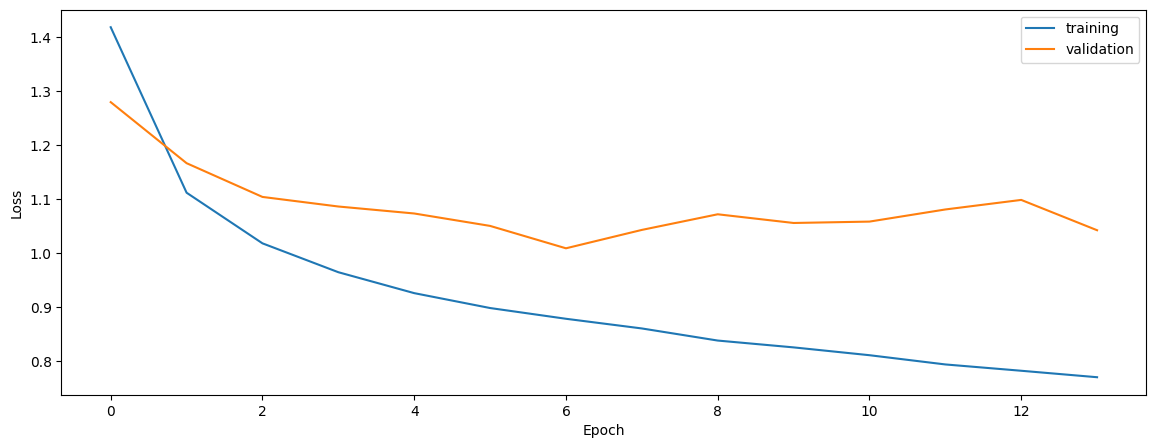

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6676593052476887
0.6168103143992145
0.6382476902531155


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.5792805536542703
0.5752608648881239
0.5364185681253


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5803080023771996
0.5679392672461216
0.5473754026909229


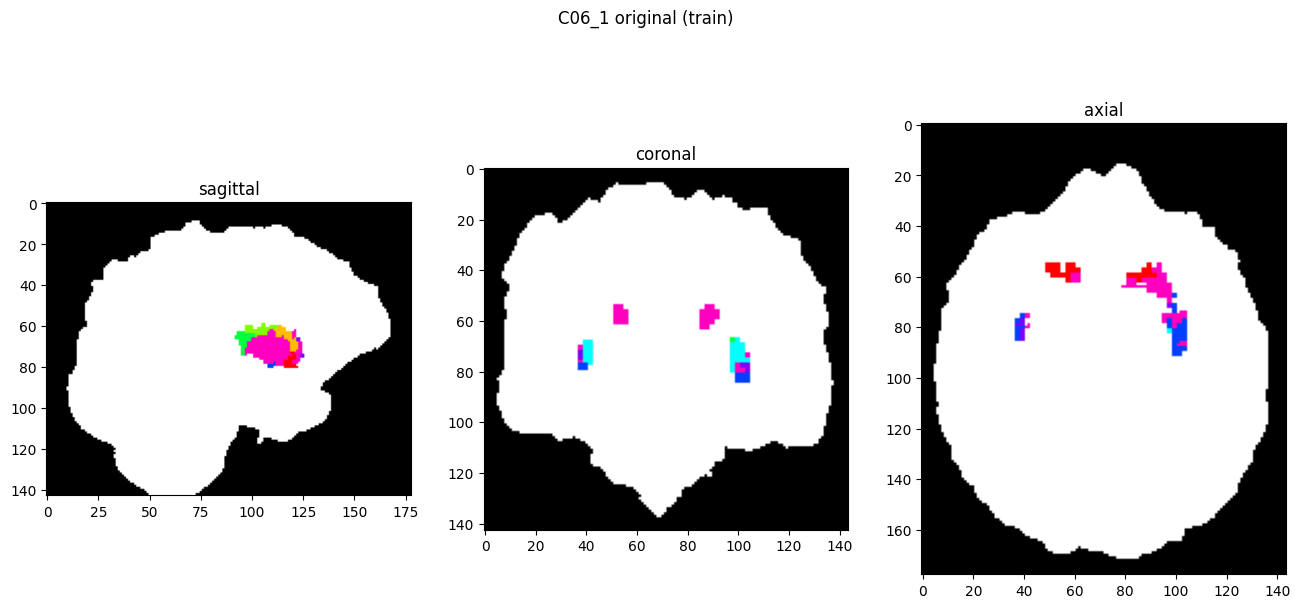

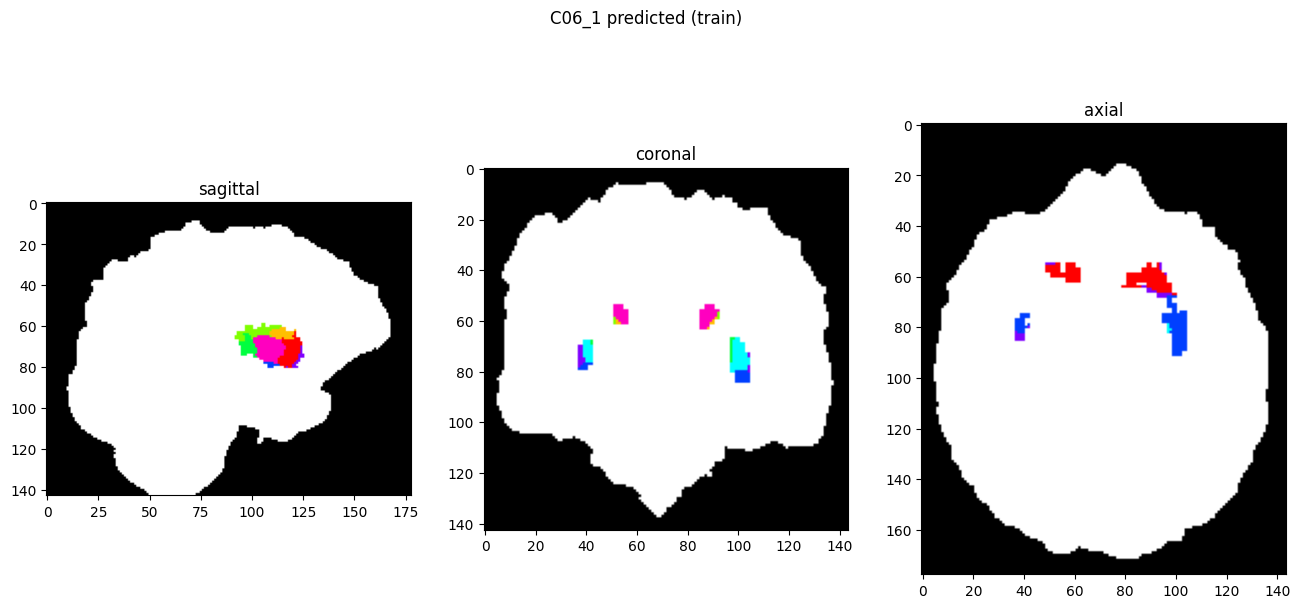

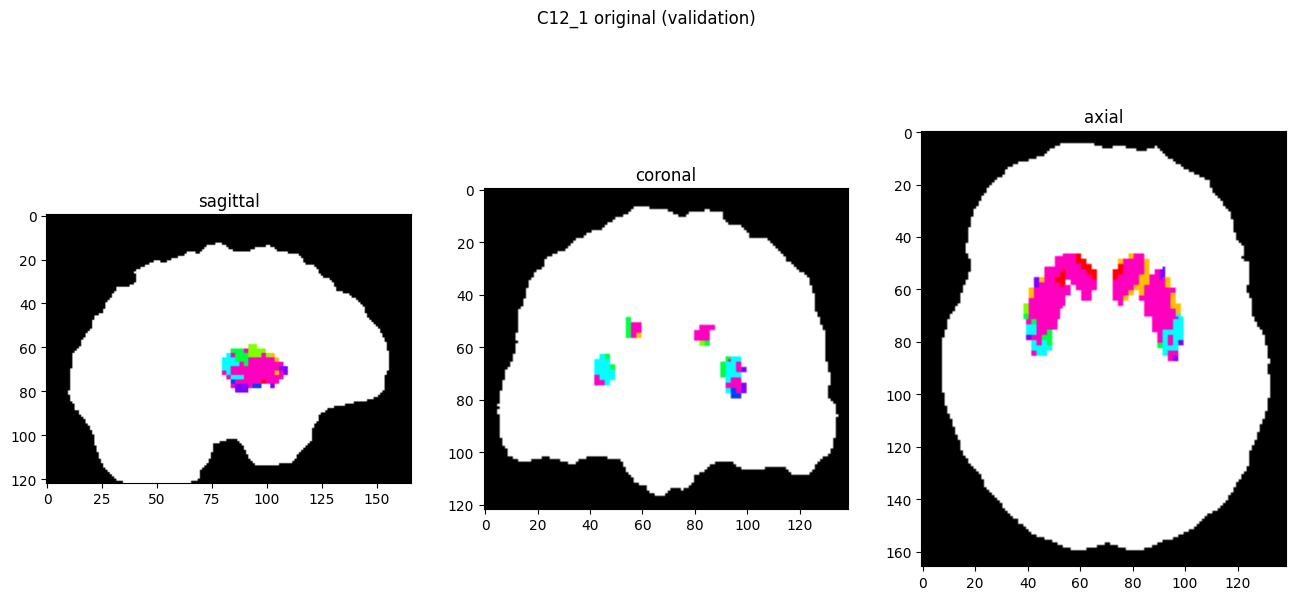

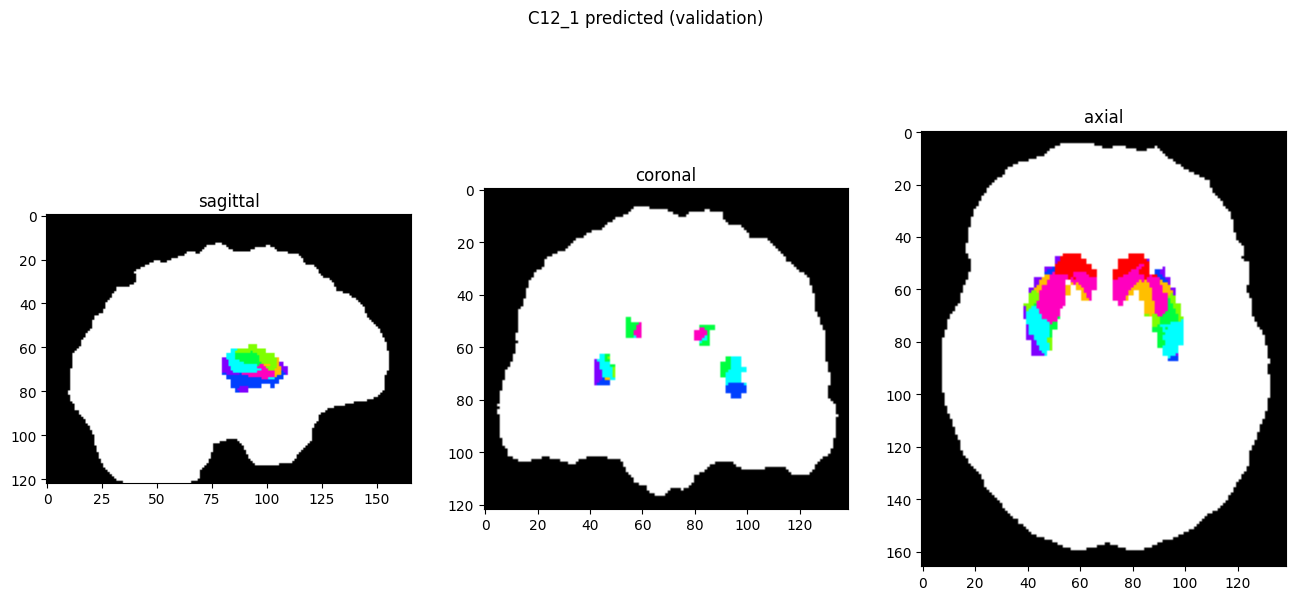

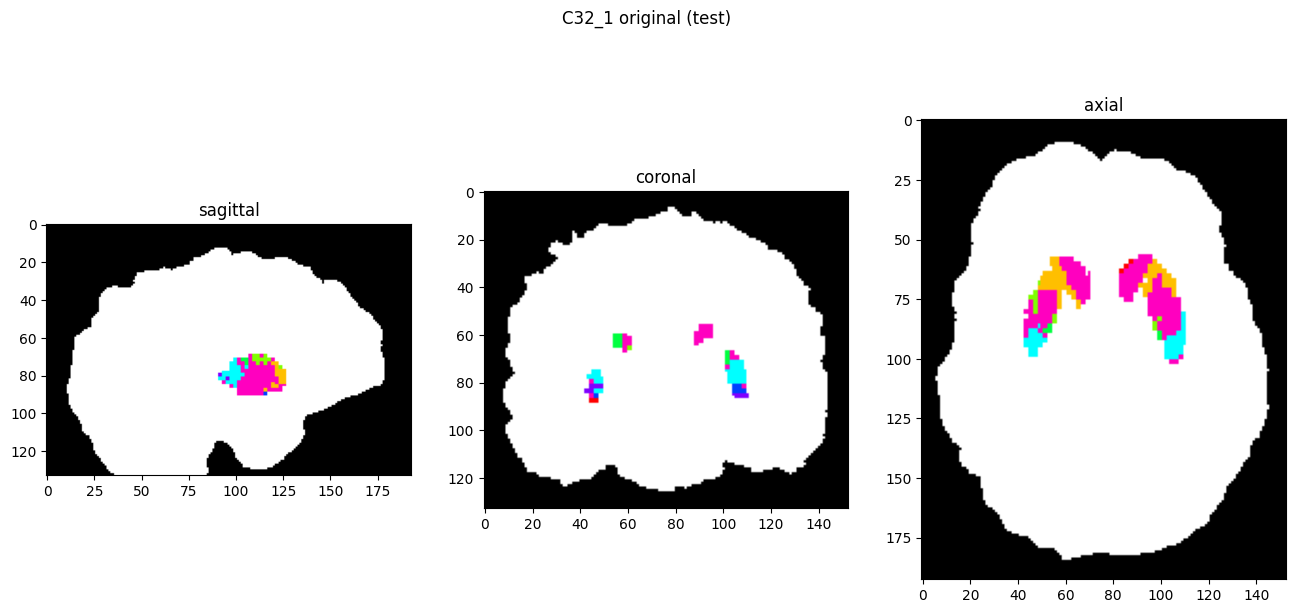

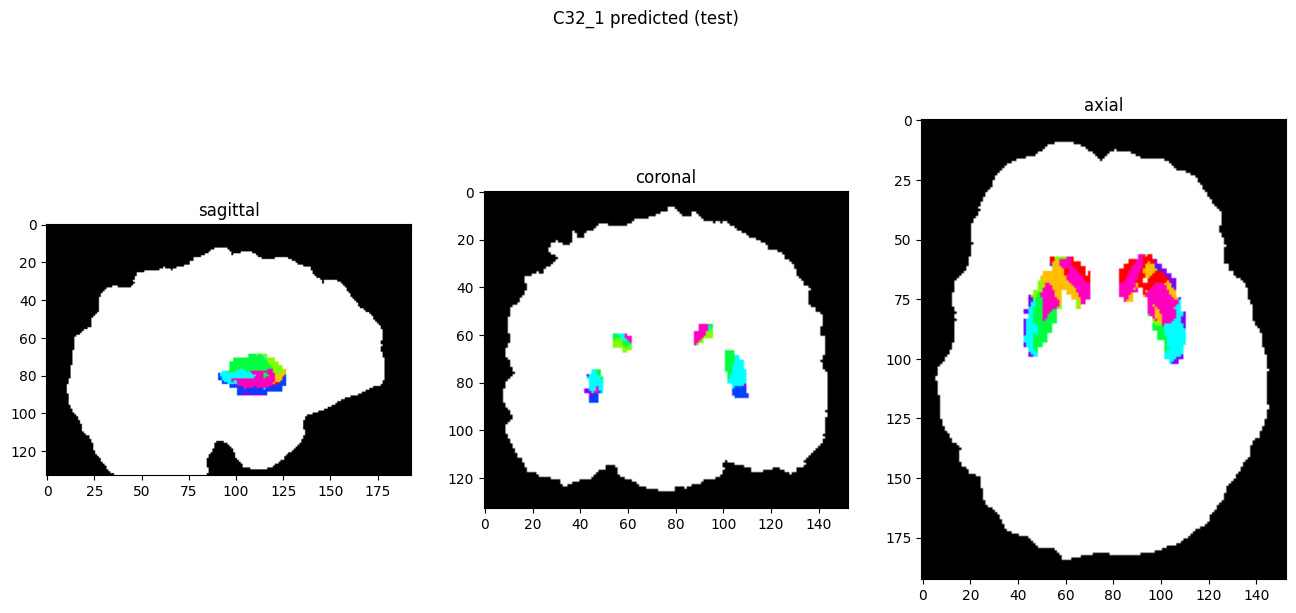

In [10]:
showResults(model, gen, threshold=0)